In [15]:
#Dependecies
#Libraries need to be installed
!pip install rdkit
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

In [2]:
#connect to your google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
## sometime need to go back and forth between Kaggle and Google Colab due to unavailability of GPUs.
# file_path = '/kaggle/input/dataset/combined_modified.csv'
# df = pd.read_csv(file_path)
file_path = '/content/drive/MyDrive/combined_modified.csv'
df = pd.read_csv(file_path)

In [4]:
##Encoding featues of atoms and bonds
#intitate feature mapping
class Featurizer:
    def __init__(self, allowable_sets):
        self.dim = 0
        self.features_mapping = {}
        for k, s in allowable_sets.items():
            s = sorted(list(s))
            self.features_mapping[k] = dict(zip(s, range(self.dim, len(s) + self.dim)))
            self.dim += len(s)

    def encode(self, inputs):
        output = np.zeros((self.dim,))
        for name_feature, feature_mapping in self.features_mapping.items():
            feature = getattr(self, name_feature)(inputs)
            if feature not in feature_mapping:
                continue
            output[feature_mapping[feature]] = 1.0
        return output

#Defining featurizer to draw atom features from the molecule
class AtomFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)

    def symbol(self, atom):
        return atom.GetSymbol()

    def n_valence(self, atom):
        return atom.GetTotalValence()

    def n_hydrogens(self, atom):
        return atom.GetTotalNumHs()

    def hybridization(self, atom):
        return atom.GetHybridization().name.lower()

#Defining featurizer to draw bond features from the molecule
class BondFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)
        self.dim += 1

    def encode(self, bond):
        output = np.zeros((self.dim,))
        if bond is None:
            output[-1] = 1.0
            return output
        output = super().encode(bond)
        return output

    def bond_type(self, bond):
        return bond.GetBondType().name.lower()

    def conjugated(self, bond):
        return bond.GetIsConjugated()

In [5]:
##Types of features we are going to work with..
#sets for atom features
atom_featurizer = AtomFeaturizer(
    allowable_sets={
        "symbol": {"B", "Br", "C", "Ca", "Cl", "F", "H", "I", "N", "Na", "O", "P", "S"},
        "n_valence": {0, 1, 2, 3, 4, 5, 6},
        "n_hydrogens": {0, 1, 2, 3, 4},
        "hybridization": {"s", "sp", "sp2", "sp3"},
    }
)
#sets for bond features
bond_featurizer = BondFeaturizer(
    allowable_sets={
        "bond_type": {"single", "double", "triple", "aromatic"},
        "conjugated": {True, False},
    }
)

In [6]:
##Process SMILES into molecular graph and make it desirable to feed in MPNN
#create molecules from SMILE (using RDKit)
def molecule_from_smiles(smiles):
    molecule = Chem.MolFromSmiles(smiles, sanitize=False)
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)
    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)
    return molecule
# creating a graph from molecule
def graph_from_molecule(molecule):
    atom_features = []
    bond_features = []
    pair_indices = []
    for atom in molecule.GetAtoms():
        atom_features.append(atom_featurizer.encode(atom))
        pair_indices.append([atom.GetIdx(), atom.GetIdx()])
        bond_features.append(bond_featurizer.encode(None))
        for neighbor in atom.GetNeighbors():
            bond = molecule.GetBondBetweenAtoms(atom.GetIdx(), neighbor.GetIdx())
            pair_indices.append([atom.GetIdx(), neighbor.GetIdx()])
            bond_features.append(bond_featurizer.encode(bond))
    return np.array(atom_features), np.array(bond_features), np.array(pair_indices)
#Processing list of SMILES and create a batch of graph representation
def graphs_from_smiles(smiles_list):
    atom_features_list = []
    bond_features_list = []
    pair_indices_list = []
    for smiles in smiles_list:
        molecule = molecule_from_smiles(smiles)
        atom_features, bond_features, pair_indices = graph_from_molecule(molecule)
        atom_features_list.append(atom_features)
        bond_features_list.append(bond_features)
        pair_indices_list.append(pair_indices)
    return (
        #create liststo Ruggedtensors (feature in Tensorflow)
        tf.ragged.constant(atom_features_list, dtype=tf.float32),
        tf.ragged.constant(bond_features_list, dtype=tf.float32),
        tf.ragged.constant(pair_indices_list, dtype=tf.int64),
    )

In [7]:
##Splitting of dataset into training and test set
#Shuffling of data
permuted_indices = np.random.permutation(np.arange(df.shape[0]))
# Training set = 80%
train_index = permuted_indices[: int(df.shape[0] * 0.8)]
x_train = graphs_from_smiles(df.iloc[train_index].Chromophore)
y_train = df.iloc[train_index].Absorption
# Test set = 20%
test_index = permuted_indices[int(df.shape[0] * 0.2) :]
x_test = graphs_from_smiles(df.iloc[test_index].Chromophore)
y_test = df.iloc[test_index].Absorption

In [8]:
## functio to prepare a batch of input data and labels.
def prepare_batch(x_batch, y_batch):
  #unpacking data from ragged tensors.
    atom_features, bond_features, pair_indices = x_batch
    num_atoms = atom_features.row_lengths()
    num_bonds = bond_features.row_lengths()
    molecule_indices = tf.range(len(num_atoms))
    molecule_indicator = tf.repeat(molecule_indices, num_atoms)

    gather_indices = tf.repeat(molecule_indices[:-1], num_bonds[1:])
    increment = tf.cumsum(num_atoms[:-1])
    increment = tf.pad(tf.gather(increment, gather_indices), [(num_bonds[0], 0)])
    pair_indices = pair_indices.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    pair_indices = pair_indices + increment[:, tf.newaxis]
    atom_features = atom_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    bond_features = bond_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()

    return (atom_features, bond_features, pair_indices, molecule_indicator), y_batch

In [9]:
#create MPNN dataset
def MPNNDataset(X, y, batch_size=32, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, (y)))
    if shuffle:
        dataset = dataset.shuffle(1024)
    return dataset.batch(batch_size).map(prepare_batch, -1).prefetch(-1)

#defining custom layer for edge(bond) network in MPNN model
class EdgeNetwork(layers.Layer):
    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.bond_dim = input_shape[1][-1]
        self.kernel = self.add_weight(
            shape=(self.bond_dim, self.atom_dim * self.atom_dim),
            initializer="glorot_uniform",
            name="kernel",
        )
        self.bias = self.add_weight(
            shape=(self.atom_dim * self.atom_dim), initializer="zeros", name="bias",
        )
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs
        bond_features = tf.matmul(bond_features, self.kernel) + self.bias
        bond_features = tf.reshape(bond_features, (-1, self.atom_dim, self.atom_dim))
        atom_features_neighbors = tf.gather(atom_features, pair_indices[:, 1])
        atom_features_neighbors = tf.expand_dims(atom_features_neighbors, axis=-1)
        transformed_features = tf.matmul(bond_features, atom_features_neighbors)
        transformed_features = tf.squeeze(transformed_features, axis=-1)
        aggregated_features = tf.math.unsorted_segment_sum(
            transformed_features,
            pair_indices[:, 0],
            num_segments=tf.shape(atom_features)[0],
        )
        return aggregated_features

In [10]:
#defining custom layer form message passing in MPNN
class MessagePassing(layers.Layer):
    def __init__(self, units, steps=4, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.steps = steps

    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.message_step = EdgeNetwork()
        self.pad_length = max(0, self.units - self.atom_dim)
        self.update_step = layers.GRUCell(self.atom_dim + self.pad_length)
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs
        atom_features_updated = tf.pad(atom_features, [(0, 0), (0, self.pad_length)])
        for i in range(self.steps):
            atom_features_aggregated = self.message_step(
                [atom_features_updated, bond_features, pair_indices]
            )
            atom_features_updated, _ = self.update_step(
                atom_features_aggregated, atom_features_updated
            )
        return atom_features_updated

In [11]:
#layer for partition padding
class PartitionPadding(layers.Layer):
    def __init__(self, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size

    def call(self, inputs):
        atom_features, molecule_indicator = inputs
        atom_features_partitioned = tf.dynamic_partition(
            atom_features, molecule_indicator, self.batch_size
        )
        num_atoms = [tf.shape(f)[0] for f in atom_features_partitioned]
        max_num_atoms = tf.reduce_max(num_atoms)
        atom_features_stacked = tf.stack(
            [
                tf.pad(f, [(0, max_num_atoms - n), (0, 0)])
                for f, n in zip(atom_features_partitioned, num_atoms)
            ],
            axis=0,
        )
        gather_indices = tf.where(tf.reduce_sum(atom_features_stacked, (1, 2)) != 0)
        gather_indices = tf.squeeze(gather_indices, axis=-1)
        return tf.gather(atom_features_stacked, gather_indices, axis=0)


In [12]:
#Layer ifor transformer encoder readout in MPNN
class TransformerEncoderReadout(layers.Layer):
    def __init__(
        self, num_heads=8, embed_dim=64, dense_dim=512, batch_size=32, **kwargs
    ):
        super().__init__(**kwargs)
#Sub-layers
        self.partition_padding = PartitionPadding(batch_size)
        self.attention = layers.MultiHeadAttention(num_heads, embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.average_pooling = layers.GlobalAveragePooling1D()

    def call(self, inputs):
      #partition padding applied
        x = self.partition_padding(inputs)
        padding_mask = tf.reduce_any(tf.not_equal(x, 0.0), axis=-1)
        padding_mask = padding_mask[:, tf.newaxis, tf.newaxis, :]
        #multi-head attention applied
        attention_output = self.attention(x, x, attention_mask=padding_mask)
        #normalisation
        proj_input = self.layernorm_1(x + attention_output)
        proj_output = self.layernorm_2(proj_input + self.dense_proj(proj_input))
        return self.average_pooling(proj_output)

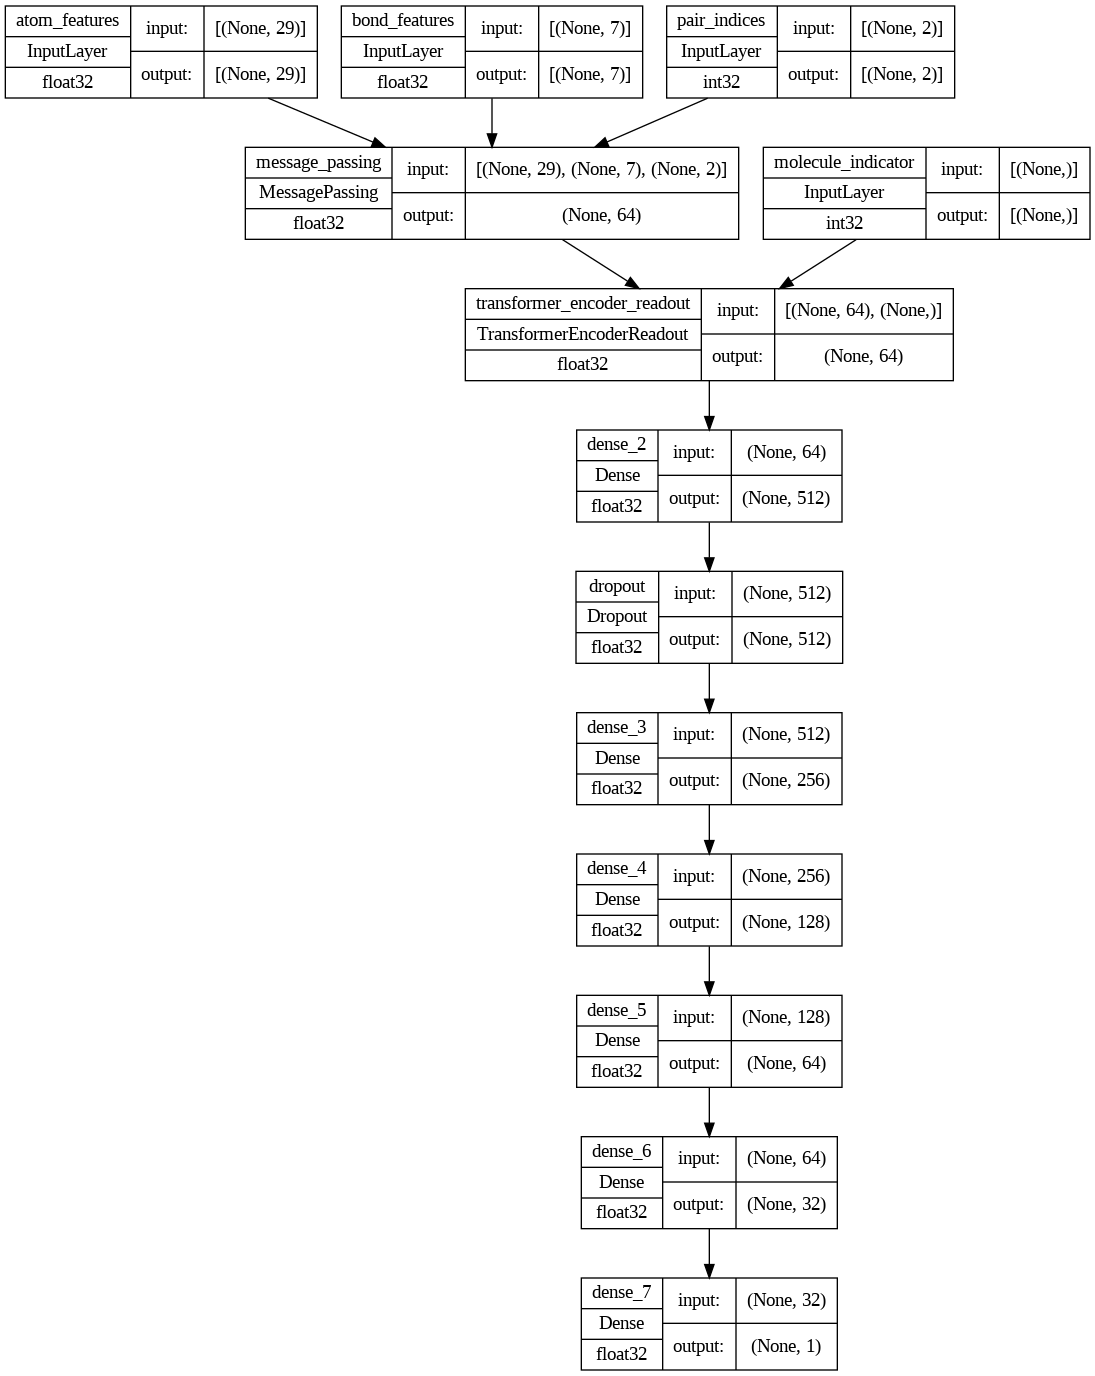

In [13]:
def MPNNModel(
    atom_dim,
    bond_dim,
    batch_size=32,
    message_units=64,
    message_steps=4,
    num_attention_heads=8,
    dense_units=512,
):
    atom_features = layers.Input((atom_dim), dtype="float32", name="atom_features")
    bond_features = layers.Input((bond_dim), dtype="float32", name="bond_features")
    pair_indices = layers.Input((2), dtype="int32", name="pair_indices")
    molecule_indicator = layers.Input((), dtype="int32", name="molecule_indicator")
    #message passing layer
    x = MessagePassing(message_units, message_steps)(
        [atom_features, bond_features, pair_indices]
    )
    #tranformer readour layer
    x = TransformerEncoderReadout(
        num_attention_heads, message_units, dense_units, batch_size
    )([x, molecule_indicator])
    # 5 dense layers with one drop out layer
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(32, activation="relu")(x)
    output_layer = layers.Dense(1, activation="linear")(x)
    model = keras.Model(
        inputs=[atom_features, bond_features, pair_indices, molecule_indicator],
        outputs=[output_layer],
    )
    return model
    #calling MPNN model
mpnn = MPNNModel(
    atom_dim=x_train[0][0][0].shape[0], bond_dim=x_train[1][0][0].shape[0],
)
mpnn.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[keras.metrics.MeanSquaredError(name="MSE")],
)
#show architecture
keras.utils.plot_model(mpnn, show_dtype=True, show_shapes=True)

Epoch 1/500
180/180 [==============================] - ETA: 0s - loss: 127628.6172 - MSE: 127628.6172

180/180 [==============================] - 23s 48ms/step - loss: 127628.6172 - MSE: 127628.6172
Epoch 2/500
179/180 [============================>.] - ETA: 0s - loss: 11264.8945 - MSE: 11264.8945

180/180 [==============================] - 6s 34ms/step - loss: 11254.5908 - MSE: 11254.5908
Epoch 3/500
179/180 [============================>.] - ETA: 0s - loss: 7909.2661 - MSE: 7909.2661

180/180 [==============================] - 5s 28ms/step - loss: 7902.6392 - MSE: 7902.6392
Epoch 4/500
180/180 [==============================] - ETA: 0s - loss: 7062.5635 - MSE: 7062.5635

180/180 [==============================] - 5s 26ms/step - loss: 7062.5635 - MSE: 7062.5635
Epoch 5/500
178/180 [============================>.] - ETA: 0s - loss: 6672.9229 - MSE: 6672.9229

180/180 [==============================] - 4s 24ms/step - loss: 6650.8608 - MSE: 6650.8608
Epoch 6/500
180/180 [==============================] - ETA: 0s - loss: 6334.5400 - MSE: 6334.5400

180/180 [==============================] - 5s 28ms/step - loss: 6334.5400 - MSE: 6334.5400
Epoch 7/500
180/180 [==============================] - ETA: 0s - loss: 6092.3403 - MSE: 6092.3403

180/180 [==============================] - 5s 27ms/step - loss: 6092.3403 - MSE: 6092.3403
Epoch 8/500
179/180 [============================>.] - ETA: 0s - loss: 5821.6245 - MSE: 5821.6245

180/180 [==============================] - 4s 24ms/step - loss: 5819.7710 - MSE: 5819.7710
Epoch 9/500
179/180 [============================>.] - ETA: 0s - loss: 5601.5874 - MSE: 5601.5874

180/180 [==============================] - 5s 29ms/step - loss: 5598.6611 - MSE: 5598.6611
Epoch 10/500
180/180 [==============================] - ETA: 0s - loss: 5521.4712 - MSE: 5521.4712

180/180 [==============================] - 5s 25ms/step - loss: 5521.4712 - MSE: 5521.4712
Epoch 11/500
179/180 [============================>.] - ETA: 0s - loss: 5404.1650 - MSE: 5404.1650

180/180 [==============================] - 4s 24ms/step - loss: 5404.5449 - MSE: 5404.5449
Epoch 12/500
180/180 [==============================] - ETA: 0s - loss: 5306.1382 - MSE: 5306.1382

180/180 [==============================] - 5s 30ms/step - loss: 5306.1382 - MSE: 5306.1382
Epoch 13/500
178/180 [============================>.] - ETA: 0s - loss: 5195.0181 - MSE: 5195.0181

180/180 [==============================] - 4s 25ms/step - loss: 5180.8906 - MSE: 5180.8906
Epoch 14/500
179/180 [============================>.] - ETA: 0s - loss: 5111.2822 - MSE: 5111.2822

180/180 [==============================] - 5s 29ms/step - loss: 5112.1572 - MSE: 5112.1572
Epoch 15/500
178/180 [============================>.] - ETA: 0s - loss: 5014.3618 - MSE: 5014.3618

180/180 [==============================] - 4s 25ms/step - loss: 5001.6743 - MSE: 5001.6743
Epoch 16/500
180/180 [==============================] - ETA: 0s - loss: 4890.1899 - MSE: 4890.1899

180/180 [==============================] - 5s 26ms/step - loss: 4890.1899 - MSE: 4890.1899
Epoch 17/500
179/180 [============================>.] - ETA: 0s - loss: 4793.2739 - MSE: 4793.2739

180/180 [==============================] - 6s 31ms/step - loss: 4793.1323 - MSE: 4793.1323
Epoch 18/500
180/180 [==============================] - ETA: 0s - loss: 4775.8247 - MSE: 4775.8247

180/180 [==============================] - 5s 29ms/step - loss: 4775.8247 - MSE: 4775.8247
Epoch 19/500
178/180 [============================>.] - ETA: 0s - loss: 4668.0508 - MSE: 4668.0508

180/180 [==============================] - 4s 25ms/step - loss: 4664.8506 - MSE: 4664.8506
Epoch 20/500
180/180 [==============================] - ETA: 0s - loss: 4630.7339 - MSE: 4630.7339

180/180 [==============================] - 5s 30ms/step - loss: 4630.7339 - MSE: 4630.7339
Epoch 21/500
180/180 [==============================] - ETA: 0s - loss: 4517.8740 - MSE: 4517.8740

180/180 [==============================] - 4s 25ms/step - loss: 4517.8740 - MSE: 4517.8740
Epoch 22/500
180/180 [==============================] - ETA: 0s - loss: 4473.2998 - MSE: 4473.2998

180/180 [==============================] - 6s 31ms/step - loss: 4473.2998 - MSE: 4473.2998
Epoch 23/500
179/180 [============================>.] - ETA: 0s - loss: 4370.6172 - MSE: 4370.6172

180/180 [==============================] - 4s 24ms/step - loss: 4373.6992 - MSE: 4373.6992
Epoch 24/500
179/180 [============================>.] - ETA: 0s - loss: 4229.7983 - MSE: 4229.7983

180/180 [==============================] - 4s 25ms/step - loss: 4234.0215 - MSE: 4234.0215
Epoch 25/500
180/180 [==============================] - ETA: 0s - loss: 4192.2153 - MSE: 4192.2153

180/180 [==============================] - 5s 29ms/step - loss: 4192.2153 - MSE: 4192.2153
Epoch 26/500
178/180 [============================>.] - ETA: 0s - loss: 4228.3555 - MSE: 4228.3555

180/180 [==============================] - 4s 24ms/step - loss: 4218.9902 - MSE: 4218.9902
Epoch 27/500
180/180 [==============================] - ETA: 0s - loss: 4058.0098 - MSE: 4058.0098

180/180 [==============================] - 5s 26ms/step - loss: 4058.0098 - MSE: 4058.0098
Epoch 28/500
179/180 [============================>.] - ETA: 0s - loss: 3958.4976 - MSE: 3958.4976

180/180 [==============================] - 5s 28ms/step - loss: 3960.8567 - MSE: 3960.8567
Epoch 29/500
180/180 [==============================] - ETA: 0s - loss: 3939.9431 - MSE: 3939.9431

180/180 [==============================] - 5s 29ms/step - loss: 3939.9431 - MSE: 3939.9431
Epoch 30/500
178/180 [============================>.] - ETA: 0s - loss: 3867.5122 - MSE: 3867.5122

180/180 [==============================] - 5s 27ms/step - loss: 3855.6660 - MSE: 3855.6660
Epoch 31/500
179/180 [============================>.] - ETA: 0s - loss: 3877.4580 - MSE: 3877.4580

180/180 [==============================] - 4s 25ms/step - loss: 3878.8469 - MSE: 3878.8469
Epoch 32/500
180/180 [==============================] - ETA: 0s - loss: 3837.4309 - MSE: 3837.4309

180/180 [==============================] - 5s 29ms/step - loss: 3837.4309 - MSE: 3837.4309
Epoch 33/500
179/180 [============================>.] - ETA: 0s - loss: 3828.9653 - MSE: 3828.9653

180/180 [==============================] - 5s 26ms/step - loss: 3831.4126 - MSE: 3831.4126
Epoch 34/500
179/180 [============================>.] - ETA: 0s - loss: 3728.4084 - MSE: 3728.4084

180/180 [==============================] - 4s 24ms/step - loss: 3727.2483 - MSE: 3727.2483
Epoch 35/500
178/180 [============================>.] - ETA: 0s - loss: 3696.5801 - MSE: 3696.5801

180/180 [==============================] - 6s 31ms/step - loss: 3687.1526 - MSE: 3687.1526
Epoch 36/500
180/180 [==============================] - ETA: 0s - loss: 3654.4460 - MSE: 3654.4460

180/180 [==============================] - 4s 25ms/step - loss: 3654.4460 - MSE: 3654.4460
Epoch 37/500
179/180 [============================>.] - ETA: 0s - loss: 3591.3066 - MSE: 3591.3066

180/180 [==============================] - 7s 39ms/step - loss: 3589.5088 - MSE: 3589.5088
Epoch 38/500
180/180 [==============================] - ETA: 0s - loss: 3576.1533 - MSE: 3576.1533

180/180 [==============================] - 7s 40ms/step - loss: 3576.1533 - MSE: 3576.1533
Epoch 39/500
178/180 [============================>.] - ETA: 0s - loss: 3528.6648 - MSE: 3528.6648

180/180 [==============================] - 5s 27ms/step - loss: 3518.9497 - MSE: 3518.9497
Epoch 40/500
180/180 [==============================] - ETA: 0s - loss: 3444.6260 - MSE: 3444.6260

180/180 [==============================] - 4s 25ms/step - loss: 3444.6260 - MSE: 3444.6260
Epoch 41/500
180/180 [==============================] - ETA: 0s - loss: 3440.9663 - MSE: 3440.9663

180/180 [==============================] - 5s 29ms/step - loss: 3440.9663 - MSE: 3440.9663
Epoch 42/500
180/180 [==============================] - ETA: 0s - loss: 3399.0864 - MSE: 3399.0864

180/180 [==============================] - 5s 25ms/step - loss: 3399.0864 - MSE: 3399.0864
Epoch 43/500
179/180 [============================>.] - ETA: 0s - loss: 3343.4829 - MSE: 3343.4829

180/180 [==============================] - 6s 31ms/step - loss: 3341.5527 - MSE: 3341.5527
Epoch 44/500
179/180 [============================>.] - ETA: 0s - loss: 3311.6582 - MSE: 3311.6582

180/180 [==============================] - 5s 25ms/step - loss: 3311.4741 - MSE: 3311.4741
Epoch 45/500
178/180 [============================>.] - ETA: 0s - loss: 3283.1172 - MSE: 3283.1172

180/180 [==============================] - 4s 25ms/step - loss: 3273.2214 - MSE: 3273.2214
Epoch 46/500
180/180 [==============================] - ETA: 0s - loss: 3195.8579 - MSE: 3195.8579

180/180 [==============================] - 6s 31ms/step - loss: 3195.8579 - MSE: 3195.8579
Epoch 47/500
178/180 [============================>.] - ETA: 0s - loss: 3241.2859 - MSE: 3241.2859

180/180 [==============================] - 4s 24ms/step - loss: 3232.9209 - MSE: 3232.9209
Epoch 48/500
179/180 [============================>.] - ETA: 0s - loss: 3123.1096 - MSE: 3123.1096

180/180 [==============================] - 4s 24ms/step - loss: 3124.5088 - MSE: 3124.5088
Epoch 49/500
178/180 [============================>.] - ETA: 0s - loss: 3186.8838 - MSE: 3186.8838

180/180 [==============================] - 6s 31ms/step - loss: 3177.0088 - MSE: 3177.0088
Epoch 50/500
178/180 [============================>.] - ETA: 0s - loss: 3143.1946 - MSE: 3143.1946

180/180 [==============================] - 4s 25ms/step - loss: 3135.4653 - MSE: 3135.4653
Epoch 51/500
179/180 [============================>.] - ETA: 0s - loss: 3072.4985 - MSE: 3072.4985

180/180 [==============================] - 4s 25ms/step - loss: 3069.6089 - MSE: 3069.6089
Epoch 52/500
179/180 [============================>.] - ETA: 0s - loss: 2972.4026 - MSE: 2972.4026

180/180 [==============================] - 5s 29ms/step - loss: 2970.0100 - MSE: 2970.0100
Epoch 53/500
179/180 [============================>.] - ETA: 0s - loss: 2953.2036 - MSE: 2953.2036

180/180 [==============================] - 6s 33ms/step - loss: 2954.1885 - MSE: 2954.1885
Epoch 54/500
179/180 [============================>.] - ETA: 0s - loss: 3038.2891 - MSE: 3038.2891

180/180 [==============================] - 5s 27ms/step - loss: 3036.2214 - MSE: 3036.2214
Epoch 55/500
179/180 [============================>.] - ETA: 0s - loss: 2931.9053 - MSE: 2931.9053

180/180 [==============================] - 6s 35ms/step - loss: 2932.2336 - MSE: 2932.2336
Epoch 56/500
178/180 [============================>.] - ETA: 0s - loss: 2895.9062 - MSE: 2895.9062

180/180 [==============================] - 5s 25ms/step - loss: 2889.2930 - MSE: 2889.2930
Epoch 57/500
180/180 [==============================] - ETA: 0s - loss: 2825.2800 - MSE: 2825.2800

180/180 [==============================] - 5s 30ms/step - loss: 2825.2800 - MSE: 2825.2800
Epoch 58/500
180/180 [==============================] - ETA: 0s - loss: 2837.8650 - MSE: 2837.8650

180/180 [==============================] - 5s 25ms/step - loss: 2837.8650 - MSE: 2837.8650
Epoch 59/500
178/180 [============================>.] - ETA: 0s - loss: 2787.6240 - MSE: 2787.6240

180/180 [==============================] - 4s 24ms/step - loss: 2781.7878 - MSE: 2781.7878
Epoch 60/500
179/180 [============================>.] - ETA: 0s - loss: 2805.0684 - MSE: 2805.0684

180/180 [==============================] - 5s 29ms/step - loss: 2803.3967 - MSE: 2803.3967
Epoch 61/500
178/180 [============================>.] - ETA: 0s - loss: 2800.5476 - MSE: 2800.5476

180/180 [==============================] - 4s 25ms/step - loss: 2794.0110 - MSE: 2794.0110
Epoch 62/500
178/180 [============================>.] - ETA: 0s - loss: 2699.9009 - MSE: 2699.9009

180/180 [==============================] - 6s 31ms/step - loss: 2700.8831 - MSE: 2700.8831
Epoch 63/500
180/180 [==============================] - ETA: 0s - loss: 2624.2366 - MSE: 2624.2366

180/180 [==============================] - 4s 25ms/step - loss: 2624.2366 - MSE: 2624.2366
Epoch 64/500
179/180 [============================>.] - ETA: 0s - loss: 2616.5383 - MSE: 2616.5383

180/180 [==============================] - 6s 31ms/step - loss: 2616.3179 - MSE: 2616.3179
Epoch 65/500
178/180 [============================>.] - ETA: 0s - loss: 2612.7061 - MSE: 2612.7061

180/180 [==============================] - 4s 25ms/step - loss: 2606.6494 - MSE: 2606.6494
Epoch 66/500
180/180 [==============================] - ETA: 0s - loss: 2587.0420 - MSE: 2587.0420

180/180 [==============================] - 6s 31ms/step - loss: 2587.0420 - MSE: 2587.0420
Epoch 67/500
179/180 [============================>.] - ETA: 0s - loss: 2598.4722 - MSE: 2598.4722

180/180 [==============================] - 5s 27ms/step - loss: 2599.1108 - MSE: 2599.1108
Epoch 68/500
179/180 [============================>.] - ETA: 0s - loss: 2521.3855 - MSE: 2521.3855

180/180 [==============================] - 5s 30ms/step - loss: 2521.5417 - MSE: 2521.5417
Epoch 69/500
180/180 [==============================] - ETA: 0s - loss: 2453.0977 - MSE: 2453.0977

180/180 [==============================] - 5s 27ms/step - loss: 2453.0977 - MSE: 2453.0977
Epoch 70/500
180/180 [==============================] - ETA: 0s - loss: 2518.1980 - MSE: 2518.1980

180/180 [==============================] - 5s 29ms/step - loss: 2518.1980 - MSE: 2518.1980
Epoch 71/500
180/180 [==============================] - ETA: 0s - loss: 2483.1897 - MSE: 2483.1897

180/180 [==============================] - 5s 27ms/step - loss: 2483.1897 - MSE: 2483.1897
Epoch 72/500
179/180 [============================>.] - ETA: 0s - loss: 2524.1553 - MSE: 2524.1553

180/180 [==============================] - 5s 28ms/step - loss: 2522.3201 - MSE: 2522.3201
Epoch 73/500
180/180 [==============================] - ETA: 0s - loss: 2505.5083 - MSE: 2505.5083

180/180 [==============================] - 4s 24ms/step - loss: 2505.5083 - MSE: 2505.5083
Epoch 74/500
179/180 [============================>.] - ETA: 0s - loss: 2401.3882 - MSE: 2401.3882

180/180 [==============================] - 5s 27ms/step - loss: 2398.0508 - MSE: 2398.0508
Epoch 75/500
179/180 [============================>.] - ETA: 0s - loss: 2366.5225 - MSE: 2366.5225

180/180 [==============================] - 5s 27ms/step - loss: 2365.4727 - MSE: 2365.4727
Epoch 76/500
180/180 [==============================] - ETA: 0s - loss: 2315.1721 - MSE: 2315.1721

180/180 [==============================] - 4s 24ms/step - loss: 2315.1721 - MSE: 2315.1721
Epoch 77/500
179/180 [============================>.] - ETA: 0s - loss: 2332.0068 - MSE: 2332.0068

180/180 [==============================] - 5s 28ms/step - loss: 2331.9214 - MSE: 2331.9214
Epoch 78/500
178/180 [============================>.] - ETA: 0s - loss: 2366.2681 - MSE: 2366.2681

180/180 [==============================] - 5s 27ms/step - loss: 2361.0549 - MSE: 2361.0549
Epoch 79/500
180/180 [==============================] - ETA: 0s - loss: 2312.2842 - MSE: 2312.2842

180/180 [==============================] - 4s 24ms/step - loss: 2312.2842 - MSE: 2312.2842
Epoch 80/500
180/180 [==============================] - ETA: 0s - loss: 2257.5850 - MSE: 2257.5850

180/180 [==============================] - 5s 28ms/step - loss: 2257.5850 - MSE: 2257.5850
Epoch 81/500
178/180 [============================>.] - ETA: 0s - loss: 2182.9768 - MSE: 2182.9768

180/180 [==============================] - 5s 27ms/step - loss: 2179.7676 - MSE: 2179.7676
Epoch 82/500
178/180 [============================>.] - ETA: 0s - loss: 2202.4119 - MSE: 2202.4119

180/180 [==============================] - 4s 24ms/step - loss: 2197.6240 - MSE: 2197.6240
Epoch 83/500
180/180 [==============================] - ETA: 0s - loss: 2140.0208 - MSE: 2140.0208

180/180 [==============================] - 5s 29ms/step - loss: 2140.0208 - MSE: 2140.0208
Epoch 84/500
178/180 [============================>.] - ETA: 0s - loss: 2148.3789 - MSE: 2148.3789

180/180 [==============================] - 5s 26ms/step - loss: 2146.2166 - MSE: 2146.2166
Epoch 85/500
178/180 [============================>.] - ETA: 0s - loss: 2091.1816 - MSE: 2091.1816

180/180 [==============================] - 5s 26ms/step - loss: 2086.3352 - MSE: 2086.3352
Epoch 86/500
180/180 [==============================] - ETA: 0s - loss: 2092.0010 - MSE: 2092.0010

180/180 [==============================] - 6s 31ms/step - loss: 2092.0010 - MSE: 2092.0010
Epoch 87/500
179/180 [============================>.] - ETA: 0s - loss: 2081.0132 - MSE: 2081.0132

180/180 [==============================] - 4s 24ms/step - loss: 2079.9265 - MSE: 2079.9265
Epoch 88/500
180/180 [==============================] - ETA: 0s - loss: 2076.9883 - MSE: 2076.9883

180/180 [==============================] - 4s 24ms/step - loss: 2076.9883 - MSE: 2076.9883
Epoch 89/500
179/180 [============================>.] - ETA: 0s - loss: 1999.5494 - MSE: 1999.5494

180/180 [==============================] - 5s 30ms/step - loss: 1998.6187 - MSE: 1998.6187
Epoch 90/500
180/180 [==============================] - ETA: 0s - loss: 2024.6494 - MSE: 2024.6494

180/180 [==============================] - 4s 25ms/step - loss: 2024.6494 - MSE: 2024.6494
Epoch 91/500
179/180 [============================>.] - ETA: 0s - loss: 2027.0280 - MSE: 2027.0280

180/180 [==============================] - 4s 24ms/step - loss: 2025.1744 - MSE: 2025.1744
Epoch 92/500
180/180 [==============================] - ETA: 0s - loss: 1997.5857 - MSE: 1997.5857

180/180 [==============================] - 5s 31ms/step - loss: 1997.5857 - MSE: 1997.5857
Epoch 93/500
178/180 [============================>.] - ETA: 0s - loss: 1933.4686 - MSE: 1933.4686

180/180 [==============================] - 4s 25ms/step - loss: 1931.9331 - MSE: 1931.9331
Epoch 94/500
179/180 [============================>.] - ETA: 0s - loss: 1953.0316 - MSE: 1953.0316

180/180 [==============================] - 4s 24ms/step - loss: 1951.6031 - MSE: 1951.6031
Epoch 95/500
179/180 [============================>.] - ETA: 0s - loss: 1975.5112 - MSE: 1975.5112

180/180 [==============================] - 6s 31ms/step - loss: 1974.7596 - MSE: 1974.7596
Epoch 96/500
180/180 [==============================] - ETA: 0s - loss: 1888.5204 - MSE: 1888.5204

180/180 [==============================] - 5s 25ms/step - loss: 1888.5204 - MSE: 1888.5204
Epoch 97/500
180/180 [==============================] - ETA: 0s - loss: 1837.6000 - MSE: 1837.6000

180/180 [==============================] - 5s 30ms/step - loss: 1837.6000 - MSE: 1837.6000
Epoch 98/500
178/180 [============================>.] - ETA: 0s - loss: 1906.0867 - MSE: 1906.0867

180/180 [==============================] - 4s 24ms/step - loss: 1901.7922 - MSE: 1901.7922
Epoch 99/500
180/180 [==============================] - ETA: 0s - loss: 1866.0851 - MSE: 1866.0851

180/180 [==============================] - 4s 25ms/step - loss: 1866.0851 - MSE: 1866.0851
Epoch 100/500
180/180 [==============================] - ETA: 0s - loss: 1777.3496 - MSE: 1777.3496

180/180 [==============================] - 5s 29ms/step - loss: 1777.3496 - MSE: 1777.3496
Epoch 101/500
180/180 [==============================] - ETA: 0s - loss: 1877.4062 - MSE: 1877.4062

180/180 [==============================] - 5s 27ms/step - loss: 1877.4062 - MSE: 1877.4062
Epoch 102/500
180/180 [==============================] - ETA: 0s - loss: 1834.4528 - MSE: 1834.4528

180/180 [==============================] - 5s 29ms/step - loss: 1834.4528 - MSE: 1834.4528
Epoch 103/500
179/180 [============================>.] - ETA: 0s - loss: 1779.3436 - MSE: 1779.3436

180/180 [==============================] - 4s 24ms/step - loss: 1778.0991 - MSE: 1778.0991
Epoch 104/500
180/180 [==============================] - ETA: 0s - loss: 1815.8109 - MSE: 1815.8109

180/180 [==============================] - 5s 27ms/step - loss: 1815.8109 - MSE: 1815.8109
Epoch 105/500
179/180 [============================>.] - ETA: 0s - loss: 1712.7397 - MSE: 1712.7397

180/180 [==============================] - 5s 28ms/step - loss: 1714.4291 - MSE: 1714.4291
Epoch 106/500
180/180 [==============================] - ETA: 0s - loss: 1719.9645 - MSE: 1719.9645

180/180 [==============================] - 4s 24ms/step - loss: 1719.9645 - MSE: 1719.9645
Epoch 107/500
179/180 [============================>.] - ETA: 0s - loss: 1708.6042 - MSE: 1708.6042

180/180 [==============================] - 5s 27ms/step - loss: 1707.4315 - MSE: 1707.4315
Epoch 108/500
178/180 [============================>.] - ETA: 0s - loss: 1696.5225 - MSE: 1696.5225

180/180 [==============================] - 5s 27ms/step - loss: 1692.3217 - MSE: 1692.3217
Epoch 109/500
178/180 [============================>.] - ETA: 0s - loss: 1668.4889 - MSE: 1668.4889

180/180 [==============================] - 4s 24ms/step - loss: 1666.3835 - MSE: 1666.3835
Epoch 110/500
179/180 [============================>.] - ETA: 0s - loss: 1735.9756 - MSE: 1735.9756

180/180 [==============================] - 5s 28ms/step - loss: 1734.7576 - MSE: 1734.7576
Epoch 111/500
180/180 [==============================] - ETA: 0s - loss: 1686.4943 - MSE: 1686.4943

180/180 [==============================] - 5s 28ms/step - loss: 1686.4943 - MSE: 1686.4943
Epoch 112/500
180/180 [==============================] - ETA: 0s - loss: 1638.0057 - MSE: 1638.0057

180/180 [==============================] - 4s 24ms/step - loss: 1638.0057 - MSE: 1638.0057
Epoch 113/500
180/180 [==============================] - ETA: 0s - loss: 1607.5327 - MSE: 1607.5327

180/180 [==============================] - 5s 29ms/step - loss: 1607.5327 - MSE: 1607.5327
Epoch 114/500
179/180 [============================>.] - ETA: 0s - loss: 1599.8406 - MSE: 1599.8406

180/180 [==============================] - 4s 25ms/step - loss: 1600.0624 - MSE: 1600.0624
Epoch 115/500
179/180 [============================>.] - ETA: 0s - loss: 1560.7238 - MSE: 1560.7238

180/180 [==============================] - 5s 30ms/step - loss: 1558.9579 - MSE: 1558.9579
Epoch 116/500
180/180 [==============================] - ETA: 0s - loss: 1579.5598 - MSE: 1579.5598

180/180 [==============================] - 4s 25ms/step - loss: 1579.5598 - MSE: 1579.5598
Epoch 117/500
178/180 [============================>.] - ETA: 0s - loss: 1588.0360 - MSE: 1588.0360

180/180 [==============================] - 6s 31ms/step - loss: 1583.1039 - MSE: 1583.1039
Epoch 118/500
178/180 [============================>.] - ETA: 0s - loss: 1622.2557 - MSE: 1622.2557

180/180 [==============================] - 4s 25ms/step - loss: 1622.8719 - MSE: 1622.8719
Epoch 119/500
179/180 [============================>.] - ETA: 0s - loss: 1574.5630 - MSE: 1574.5630

180/180 [==============================] - 5s 30ms/step - loss: 1573.8970 - MSE: 1573.8970
Epoch 120/500
179/180 [============================>.] - ETA: 0s - loss: 1492.9055 - MSE: 1492.9055

180/180 [==============================] - 5s 26ms/step - loss: 1492.4828 - MSE: 1492.4828
Epoch 121/500
180/180 [==============================] - ETA: 0s - loss: 1580.2032 - MSE: 1580.2032

180/180 [==============================] - 5s 29ms/step - loss: 1580.2032 - MSE: 1580.2032
Epoch 122/500
180/180 [==============================] - ETA: 0s - loss: 1516.0835 - MSE: 1516.0835

180/180 [==============================] - 5s 27ms/step - loss: 1516.0835 - MSE: 1516.0835
Epoch 123/500
179/180 [============================>.] - ETA: 0s - loss: 1492.1169 - MSE: 1492.1169

180/180 [==============================] - 5s 28ms/step - loss: 1491.1205 - MSE: 1491.1205
Epoch 124/500
179/180 [============================>.] - ETA: 0s - loss: 1497.1088 - MSE: 1497.1088

180/180 [==============================] - 4s 24ms/step - loss: 1496.3329 - MSE: 1496.3329
Epoch 125/500
180/180 [==============================] - ETA: 0s - loss: 1518.8149 - MSE: 1518.8149

180/180 [==============================] - 5s 28ms/step - loss: 1518.8149 - MSE: 1518.8149
Epoch 126/500
178/180 [============================>.] - ETA: 0s - loss: 1483.3413 - MSE: 1483.3413

180/180 [==============================] - 4s 24ms/step - loss: 1481.5580 - MSE: 1481.5580
Epoch 127/500
180/180 [==============================] - ETA: 0s - loss: 1484.8397 - MSE: 1484.8397

180/180 [==============================] - 5s 30ms/step - loss: 1484.8397 - MSE: 1484.8397
Epoch 128/500
178/180 [============================>.] - ETA: 0s - loss: 1458.4938 - MSE: 1458.4938

180/180 [==============================] - 4s 25ms/step - loss: 1456.3009 - MSE: 1456.3009
Epoch 129/500
178/180 [============================>.] - ETA: 0s - loss: 1455.1583 - MSE: 1455.1583

180/180 [==============================] - 5s 31ms/step - loss: 1451.6886 - MSE: 1451.6886
Epoch 130/500
180/180 [==============================] - ETA: 0s - loss: 1463.6969 - MSE: 1463.6969

180/180 [==============================] - 4s 24ms/step - loss: 1463.6969 - MSE: 1463.6969
Epoch 131/500
179/180 [============================>.] - ETA: 0s - loss: 1406.8215 - MSE: 1406.8215

180/180 [==============================] - 4s 24ms/step - loss: 1406.4803 - MSE: 1406.4803
Epoch 132/500
179/180 [============================>.] - ETA: 0s - loss: 1409.9412 - MSE: 1409.9412

180/180 [==============================] - 6s 31ms/step - loss: 1409.5768 - MSE: 1409.5768
Epoch 133/500
178/180 [============================>.] - ETA: 0s - loss: 1432.1707 - MSE: 1432.1707

180/180 [==============================] - 5s 25ms/step - loss: 1428.5649 - MSE: 1428.5649
Epoch 134/500
179/180 [============================>.] - ETA: 0s - loss: 1384.4656 - MSE: 1384.4656

180/180 [==============================] - 4s 25ms/step - loss: 1383.7961 - MSE: 1383.7961
Epoch 135/500
178/180 [============================>.] - ETA: 0s - loss: 1371.9354 - MSE: 1371.9354

180/180 [==============================] - 5s 29ms/step - loss: 1370.1315 - MSE: 1370.1315
Epoch 136/500
178/180 [============================>.] - ETA: 0s - loss: 1375.2197 - MSE: 1375.2197

180/180 [==============================] - 4s 25ms/step - loss: 1371.1442 - MSE: 1371.1442
Epoch 137/500
180/180 [==============================] - ETA: 0s - loss: 1379.3014 - MSE: 1379.3014

180/180 [==============================] - 5s 26ms/step - loss: 1379.3014 - MSE: 1379.3014
Epoch 138/500
180/180 [==============================] - ETA: 0s - loss: 1391.4359 - MSE: 1391.4359

180/180 [==============================] - 5s 29ms/step - loss: 1391.4359 - MSE: 1391.4359
Epoch 139/500
179/180 [============================>.] - ETA: 0s - loss: 1337.3278 - MSE: 1337.3278

180/180 [==============================] - 4s 25ms/step - loss: 1336.8379 - MSE: 1336.8379
Epoch 140/500
180/180 [==============================] - ETA: 0s - loss: 1321.0579 - MSE: 1321.0579

180/180 [==============================] - 5s 28ms/step - loss: 1321.0579 - MSE: 1321.0579
Epoch 141/500
179/180 [============================>.] - ETA: 0s - loss: 1249.4725 - MSE: 1249.4725

180/180 [==============================] - 7s 37ms/step - loss: 1248.6378 - MSE: 1248.6378
Epoch 142/500
178/180 [============================>.] - ETA: 0s - loss: 1285.3331 - MSE: 1285.3331

180/180 [==============================] - 4s 25ms/step - loss: 1282.8177 - MSE: 1282.8177
Epoch 143/500
178/180 [============================>.] - ETA: 0s - loss: 1253.9766 - MSE: 1253.9766

180/180 [==============================] - 5s 30ms/step - loss: 1251.1445 - MSE: 1251.1445
Epoch 144/500
178/180 [============================>.] - ETA: 0s - loss: 1235.7690 - MSE: 1235.7690

180/180 [==============================] - 4s 24ms/step - loss: 1232.6162 - MSE: 1232.6162
Epoch 145/500
180/180 [==============================] - ETA: 0s - loss: 1260.3771 - MSE: 1260.3771

180/180 [==============================] - 4s 24ms/step - loss: 1260.3771 - MSE: 1260.3771
Epoch 146/500
180/180 [==============================] - ETA: 0s - loss: 1271.8204 - MSE: 1271.8204

180/180 [==============================] - 6s 31ms/step - loss: 1271.8204 - MSE: 1271.8204
Epoch 147/500
180/180 [==============================] - ETA: 0s - loss: 1241.6707 - MSE: 1241.6707

180/180 [==============================] - 4s 25ms/step - loss: 1241.6707 - MSE: 1241.6707
Epoch 148/500
179/180 [============================>.] - ETA: 0s - loss: 1245.8414 - MSE: 1245.8414

180/180 [==============================] - 5s 25ms/step - loss: 1244.8004 - MSE: 1244.8004
Epoch 149/500
179/180 [============================>.] - ETA: 0s - loss: 1252.6996 - MSE: 1252.6996

180/180 [==============================] - 5s 30ms/step - loss: 1253.2041 - MSE: 1253.2041
Epoch 150/500
180/180 [==============================] - ETA: 0s - loss: 1230.2845 - MSE: 1230.2845

180/180 [==============================] - 5s 26ms/step - loss: 1230.2845 - MSE: 1230.2845
Epoch 151/500
178/180 [============================>.] - ETA: 0s - loss: 1262.3896 - MSE: 1262.3896

180/180 [==============================] - 5s 30ms/step - loss: 1258.1219 - MSE: 1258.1219
Epoch 152/500
179/180 [============================>.] - ETA: 0s - loss: 1254.6099 - MSE: 1254.6099

180/180 [==============================] - 4s 24ms/step - loss: 1255.5410 - MSE: 1255.5410
Epoch 153/500
180/180 [==============================] - ETA: 0s - loss: 1185.8840 - MSE: 1185.8840

180/180 [==============================] - 5s 25ms/step - loss: 1185.8840 - MSE: 1185.8840
Epoch 154/500
178/180 [============================>.] - ETA: 0s - loss: 1132.4651 - MSE: 1132.4651

180/180 [==============================] - 5s 30ms/step - loss: 1130.2791 - MSE: 1130.2791
Epoch 155/500
179/180 [============================>.] - ETA: 0s - loss: 1161.8779 - MSE: 1161.8779

180/180 [==============================] - 5s 26ms/step - loss: 1161.8175 - MSE: 1161.8175
Epoch 156/500
180/180 [==============================] - ETA: 0s - loss: 1175.7365 - MSE: 1175.7365

180/180 [==============================] - 5s 29ms/step - loss: 1175.7365 - MSE: 1175.7365
Epoch 157/500
180/180 [==============================] - ETA: 0s - loss: 1172.0258 - MSE: 1172.0258

180/180 [==============================] - 5s 27ms/step - loss: 1172.0258 - MSE: 1172.0258
Epoch 158/500
180/180 [==============================] - ETA: 0s - loss: 1148.3149 - MSE: 1148.3149

180/180 [==============================] - 5s 28ms/step - loss: 1148.3149 - MSE: 1148.3149
Epoch 159/500
179/180 [============================>.] - ETA: 0s - loss: 1150.1332 - MSE: 1150.1332

180/180 [==============================] - 4s 24ms/step - loss: 1150.0912 - MSE: 1150.0912
Epoch 160/500
179/180 [============================>.] - ETA: 0s - loss: 1154.7952 - MSE: 1154.7952

180/180 [==============================] - 5s 27ms/step - loss: 1154.9667 - MSE: 1154.9667
Epoch 161/500
179/180 [============================>.] - ETA: 0s - loss: 1096.7052 - MSE: 1096.7052

180/180 [==============================] - 5s 28ms/step - loss: 1096.5448 - MSE: 1096.5448
Epoch 162/500
180/180 [==============================] - ETA: 0s - loss: 1095.1552 - MSE: 1095.1552

180/180 [==============================] - 5s 28ms/step - loss: 1095.1552 - MSE: 1095.1552
Epoch 163/500
179/180 [============================>.] - ETA: 0s - loss: 1109.2152 - MSE: 1109.2152

180/180 [==============================] - 5s 28ms/step - loss: 1108.6842 - MSE: 1108.6842
Epoch 164/500
180/180 [==============================] - ETA: 0s - loss: 1055.2784 - MSE: 1055.2784

180/180 [==============================] - 4s 24ms/step - loss: 1055.2784 - MSE: 1055.2784
Epoch 165/500
180/180 [==============================] - ETA: 0s - loss: 1116.6917 - MSE: 1116.6917

180/180 [==============================] - 5s 29ms/step - loss: 1116.6917 - MSE: 1116.6917
Epoch 166/500
179/180 [============================>.] - ETA: 0s - loss: 1113.7823 - MSE: 1113.7823

180/180 [==============================] - 4s 25ms/step - loss: 1113.1605 - MSE: 1113.1605
Epoch 167/500
179/180 [============================>.] - ETA: 0s - loss: 1064.7974 - MSE: 1064.7974

180/180 [==============================] - 6s 31ms/step - loss: 1063.9213 - MSE: 1063.9213
Epoch 168/500
180/180 [==============================] - ETA: 0s - loss: 1055.2048 - MSE: 1055.2048

180/180 [==============================] - 4s 25ms/step - loss: 1055.2048 - MSE: 1055.2048
Epoch 169/500
179/180 [============================>.] - ETA: 0s - loss: 1078.9935 - MSE: 1078.9935

180/180 [==============================] - 6s 31ms/step - loss: 1079.1584 - MSE: 1079.1584
Epoch 170/500
179/180 [============================>.] - ETA: 0s - loss: 1064.2357 - MSE: 1064.2357

180/180 [==============================] - 4s 24ms/step - loss: 1064.2708 - MSE: 1064.2708
Epoch 171/500
179/180 [============================>.] - ETA: 0s - loss: 1052.5029 - MSE: 1052.5029

180/180 [==============================] - 4s 24ms/step - loss: 1051.5681 - MSE: 1051.5681
Epoch 172/500
180/180 [==============================] - ETA: 0s - loss: 1060.9401 - MSE: 1060.9401

180/180 [==============================] - 6s 31ms/step - loss: 1060.9401 - MSE: 1060.9401
Epoch 173/500
179/180 [============================>.] - ETA: 0s - loss: 1032.9049 - MSE: 1032.9049

180/180 [==============================] - 4s 25ms/step - loss: 1032.4203 - MSE: 1032.4203
Epoch 174/500
178/180 [============================>.] - ETA: 0s - loss: 1079.6526 - MSE: 1079.6526

180/180 [==============================] - 5s 30ms/step - loss: 1080.9558 - MSE: 1080.9558
Epoch 175/500
178/180 [============================>.] - ETA: 0s - loss: 1007.4691 - MSE: 1007.4691

180/180 [==============================] - 4s 24ms/step - loss: 1005.8033 - MSE: 1005.8033
Epoch 176/500
179/180 [============================>.] - ETA: 0s - loss: 1019.6229 - MSE: 1019.6229

180/180 [==============================] - 5s 25ms/step - loss: 1018.9230 - MSE: 1018.9230
Epoch 177/500
179/180 [============================>.] - ETA: 0s - loss: 1010.6740 - MSE: 1010.6740

180/180 [==============================] - 5s 30ms/step - loss: 1010.4369 - MSE: 1010.4369
Epoch 178/500
179/180 [============================>.] - ETA: 0s - loss: 976.9565 - MSE: 976.9565

180/180 [==============================] - 5s 26ms/step - loss: 977.1600 - MSE: 977.1600
Epoch 179/500
178/180 [============================>.] - ETA: 0s - loss: 1056.9745 - MSE: 1056.9745

180/180 [==============================] - 5s 30ms/step - loss: 1054.5798 - MSE: 1054.5798
Epoch 180/500
180/180 [==============================] - ETA: 0s - loss: 1001.2449 - MSE: 1001.2449

180/180 [==============================] - 5s 26ms/step - loss: 1001.2449 - MSE: 1001.2449
Epoch 181/500
179/180 [============================>.] - ETA: 0s - loss: 962.0232 - MSE: 962.0232

180/180 [==============================] - 5s 29ms/step - loss: 961.9212 - MSE: 961.9212
Epoch 182/500
178/180 [============================>.] - ETA: 0s - loss: 1004.8842 - MSE: 1004.8842

180/180 [==============================] - 4s 25ms/step - loss: 1004.8121 - MSE: 1004.8121
Epoch 183/500
180/180 [==============================] - ETA: 0s - loss: 955.1899 - MSE: 955.1899

180/180 [==============================] - 5s 26ms/step - loss: 955.1899 - MSE: 955.1899
Epoch 184/500
179/180 [============================>.] - ETA: 0s - loss: 988.5404 - MSE: 988.5404

180/180 [==============================] - 5s 28ms/step - loss: 988.3699 - MSE: 988.3699
Epoch 185/500
180/180 [==============================] - ETA: 0s - loss: 1002.8854 - MSE: 1002.8854

180/180 [==============================] - 4s 24ms/step - loss: 1002.8854 - MSE: 1002.8854
Epoch 186/500
179/180 [============================>.] - ETA: 0s - loss: 994.6682 - MSE: 994.6682

180/180 [==============================] - 5s 28ms/step - loss: 994.5323 - MSE: 994.5323
Epoch 187/500
180/180 [==============================] - ETA: 0s - loss: 1008.2780 - MSE: 1008.2780

180/180 [==============================] - 5s 27ms/step - loss: 1008.2780 - MSE: 1008.2780
Epoch 188/500
178/180 [============================>.] - ETA: 0s - loss: 958.5613 - MSE: 958.5613

180/180 [==============================] - 4s 24ms/step - loss: 957.2942 - MSE: 957.2942
Epoch 189/500
179/180 [============================>.] - ETA: 0s - loss: 978.3795 - MSE: 978.3795

180/180 [==============================] - 5s 29ms/step - loss: 977.5409 - MSE: 977.5409
Epoch 190/500
179/180 [============================>.] - ETA: 0s - loss: 939.9182 - MSE: 939.9182

180/180 [==============================] - 5s 26ms/step - loss: 940.6265 - MSE: 940.6265
Epoch 191/500
180/180 [==============================] - ETA: 0s - loss: 945.5270 - MSE: 945.5270

180/180 [==============================] - 4s 24ms/step - loss: 945.5270 - MSE: 945.5270
Epoch 192/500
179/180 [============================>.] - ETA: 0s - loss: 946.5181 - MSE: 946.5181

180/180 [==============================] - 5s 31ms/step - loss: 945.7844 - MSE: 945.7844
Epoch 193/500
178/180 [============================>.] - ETA: 0s - loss: 946.8956 - MSE: 946.8956

180/180 [==============================] - 4s 24ms/step - loss: 945.2169 - MSE: 945.2169
Epoch 194/500
179/180 [============================>.] - ETA: 0s - loss: 921.5934 - MSE: 921.5934

180/180 [==============================] - 4s 25ms/step - loss: 920.5896 - MSE: 920.5896
Epoch 195/500
179/180 [============================>.] - ETA: 0s - loss: 876.0079 - MSE: 876.0079

180/180 [==============================] - 5s 30ms/step - loss: 875.4069 - MSE: 875.4069
Epoch 196/500
179/180 [============================>.] - ETA: 0s - loss: 946.4170 - MSE: 946.4170

180/180 [==============================] - 5s 27ms/step - loss: 945.6125 - MSE: 945.6125
Epoch 197/500
179/180 [============================>.] - ETA: 0s - loss: 884.1345 - MSE: 884.1345

180/180 [==============================] - 5s 29ms/step - loss: 883.7241 - MSE: 883.7241
Epoch 198/500
179/180 [============================>.] - ETA: 0s - loss: 938.3951 - MSE: 938.3951

180/180 [==============================] - 5s 28ms/step - loss: 937.9122 - MSE: 937.9122
Epoch 199/500
180/180 [==============================] - ETA: 0s - loss: 838.3763 - MSE: 838.3763

180/180 [==============================] - 5s 28ms/step - loss: 838.3763 - MSE: 838.3763
Epoch 200/500
178/180 [============================>.] - ETA: 0s - loss: 938.3835 - MSE: 938.3835

180/180 [==============================] - 4s 25ms/step - loss: 938.1725 - MSE: 938.1725
Epoch 201/500
180/180 [==============================] - ETA: 0s - loss: 901.2135 - MSE: 901.2135

180/180 [==============================] - 5s 28ms/step - loss: 901.2135 - MSE: 901.2135
Epoch 202/500
178/180 [============================>.] - ETA: 0s - loss: 874.1713 - MSE: 874.1713

180/180 [==============================] - 5s 28ms/step - loss: 873.0031 - MSE: 873.0031
Epoch 203/500
180/180 [==============================] - ETA: 0s - loss: 856.8680 - MSE: 856.8680

180/180 [==============================] - 4s 24ms/step - loss: 856.8680 - MSE: 856.8680
Epoch 204/500
180/180 [==============================] - ETA: 0s - loss: 875.5457 - MSE: 875.5457

180/180 [==============================] - 5s 29ms/step - loss: 875.5457 - MSE: 875.5457
Epoch 205/500
180/180 [==============================] - ETA: 0s - loss: 844.9615 - MSE: 844.9615

180/180 [==============================] - 5s 27ms/step - loss: 844.9615 - MSE: 844.9615
Epoch 206/500
178/180 [============================>.] - ETA: 0s - loss: 843.2793 - MSE: 843.2793

180/180 [==============================] - 4s 24ms/step - loss: 845.0975 - MSE: 845.0975
Epoch 207/500
179/180 [============================>.] - ETA: 0s - loss: 921.9894 - MSE: 921.9894

180/180 [==============================] - 5s 28ms/step - loss: 921.1164 - MSE: 921.1164
Epoch 208/500
180/180 [==============================] - ETA: 0s - loss: 865.6896 - MSE: 865.6896

180/180 [==============================] - 5s 25ms/step - loss: 865.6896 - MSE: 865.6896
Epoch 209/500
179/180 [============================>.] - ETA: 0s - loss: 882.2815 - MSE: 882.2815

180/180 [==============================] - 5s 30ms/step - loss: 882.1178 - MSE: 882.1178
Epoch 210/500
179/180 [============================>.] - ETA: 0s - loss: 871.5319 - MSE: 871.5319

180/180 [==============================] - 5s 25ms/step - loss: 870.8560 - MSE: 870.8560
Epoch 211/500
179/180 [============================>.] - ETA: 0s - loss: 823.2731 - MSE: 823.2731

180/180 [==============================] - 4s 25ms/step - loss: 823.2038 - MSE: 823.2038
Epoch 212/500
178/180 [============================>.] - ETA: 0s - loss: 804.5418 - MSE: 804.5418

180/180 [==============================] - 6s 31ms/step - loss: 804.5350 - MSE: 804.5350
Epoch 213/500
180/180 [==============================] - ETA: 0s - loss: 821.7357 - MSE: 821.7357

180/180 [==============================] - 5s 25ms/step - loss: 821.7357 - MSE: 821.7357
Epoch 214/500
179/180 [============================>.] - ETA: 0s - loss: 836.7961 - MSE: 836.7961

180/180 [==============================] - 5s 30ms/step - loss: 836.4479 - MSE: 836.4479
Epoch 215/500
179/180 [============================>.] - ETA: 0s - loss: 800.2637 - MSE: 800.2637

180/180 [==============================] - 5s 27ms/step - loss: 799.4209 - MSE: 799.4209
Epoch 216/500
178/180 [============================>.] - ETA: 0s - loss: 817.0974 - MSE: 817.0974

180/180 [==============================] - 5s 28ms/step - loss: 815.3575 - MSE: 815.3575
Epoch 217/500
180/180 [==============================] - ETA: 0s - loss: 785.2129 - MSE: 785.2129

180/180 [==============================] - 4s 25ms/step - loss: 785.2129 - MSE: 785.2129
Epoch 218/500
180/180 [==============================] - ETA: 0s - loss: 816.1849 - MSE: 816.1849

180/180 [==============================] - 5s 28ms/step - loss: 816.1849 - MSE: 816.1849
Epoch 219/500
180/180 [==============================] - ETA: 0s - loss: 772.1187 - MSE: 772.1187

180/180 [==============================] - 5s 28ms/step - loss: 772.1187 - MSE: 772.1187
Epoch 220/500
180/180 [==============================] - ETA: 0s - loss: 752.1677 - MSE: 752.1677

180/180 [==============================] - 4s 24ms/step - loss: 752.1677 - MSE: 752.1677
Epoch 221/500
179/180 [============================>.] - ETA: 0s - loss: 817.0873 - MSE: 817.0873

180/180 [==============================] - 5s 27ms/step - loss: 816.1110 - MSE: 816.1110
Epoch 222/500
180/180 [==============================] - ETA: 0s - loss: 777.1254 - MSE: 777.1254

180/180 [==============================] - 5s 28ms/step - loss: 777.1254 - MSE: 777.1254
Epoch 223/500
180/180 [==============================] - ETA: 0s - loss: 823.6636 - MSE: 823.6636

180/180 [==============================] - 4s 24ms/step - loss: 823.6636 - MSE: 823.6636
Epoch 224/500
179/180 [============================>.] - ETA: 0s - loss: 804.7767 - MSE: 804.7767

180/180 [==============================] - 5s 26ms/step - loss: 804.4265 - MSE: 804.4265
Epoch 225/500
178/180 [============================>.] - ETA: 0s - loss: 785.3926 - MSE: 785.3926

180/180 [==============================] - 5s 29ms/step - loss: 784.0795 - MSE: 784.0795
Epoch 226/500
178/180 [============================>.] - ETA: 0s - loss: 821.8447 - MSE: 821.8447

180/180 [==============================] - 4s 24ms/step - loss: 820.7607 - MSE: 820.7607
Epoch 227/500
180/180 [==============================] - ETA: 0s - loss: 763.7801 - MSE: 763.7801

180/180 [==============================] - 5s 28ms/step - loss: 763.7801 - MSE: 763.7801
Epoch 228/500
179/180 [============================>.] - ETA: 0s - loss: 766.5120 - MSE: 766.5120

180/180 [==============================] - 6s 32ms/step - loss: 765.8836 - MSE: 765.8836
Epoch 229/500
180/180 [==============================] - ETA: 0s - loss: 799.3835 - MSE: 799.3835

180/180 [==============================] - 5s 30ms/step - loss: 799.3835 - MSE: 799.3835
Epoch 230/500
179/180 [============================>.] - ETA: 0s - loss: 733.2986 - MSE: 733.2986

180/180 [==============================] - 5s 26ms/step - loss: 732.8885 - MSE: 732.8885
Epoch 231/500
179/180 [============================>.] - ETA: 0s - loss: 807.9909 - MSE: 807.9909

180/180 [==============================] - 4s 24ms/step - loss: 807.6537 - MSE: 807.6537
Epoch 232/500
180/180 [==============================] - ETA: 0s - loss: 734.8795 - MSE: 734.8795

180/180 [==============================] - 6s 31ms/step - loss: 734.8795 - MSE: 734.8795
Epoch 233/500
179/180 [============================>.] - ETA: 0s - loss: 736.1852 - MSE: 736.1852

180/180 [==============================] - 4s 25ms/step - loss: 735.5541 - MSE: 735.5541
Epoch 234/500
179/180 [============================>.] - ETA: 0s - loss: 726.6464 - MSE: 726.6464

180/180 [==============================] - 5s 31ms/step - loss: 726.0370 - MSE: 726.0370
Epoch 235/500
180/180 [==============================] - ETA: 0s - loss: 750.3598 - MSE: 750.3598

180/180 [==============================] - 5s 25ms/step - loss: 750.3598 - MSE: 750.3598
Epoch 236/500
179/180 [============================>.] - ETA: 0s - loss: 751.2299 - MSE: 751.2299

180/180 [==============================] - 6s 31ms/step - loss: 750.4486 - MSE: 750.4486
Epoch 237/500
180/180 [==============================] - ETA: 0s - loss: 782.6775 - MSE: 782.6775

180/180 [==============================] - 4s 24ms/step - loss: 782.6775 - MSE: 782.6775
Epoch 238/500
180/180 [==============================] - ETA: 0s - loss: 756.7987 - MSE: 756.7987

180/180 [==============================] - 4s 24ms/step - loss: 756.7987 - MSE: 756.7987
Epoch 239/500
179/180 [============================>.] - ETA: 0s - loss: 732.2885 - MSE: 732.2885

180/180 [==============================] - 5s 30ms/step - loss: 733.0171 - MSE: 733.0171
Epoch 240/500
180/180 [==============================] - ETA: 0s - loss: 697.7344 - MSE: 697.7344

180/180 [==============================] - 4s 24ms/step - loss: 697.7344 - MSE: 697.7344
Epoch 241/500
179/180 [============================>.] - ETA: 0s - loss: 702.5715 - MSE: 702.5715

180/180 [==============================] - 4s 25ms/step - loss: 702.1992 - MSE: 702.1992
Epoch 242/500
180/180 [==============================] - ETA: 0s - loss: 739.7549 - MSE: 739.7549

180/180 [==============================] - 5s 29ms/step - loss: 739.7549 - MSE: 739.7549
Epoch 243/500
178/180 [============================>.] - ETA: 0s - loss: 702.3143 - MSE: 702.3143

180/180 [==============================] - 4s 24ms/step - loss: 701.4005 - MSE: 701.4005
Epoch 244/500
180/180 [==============================] - ETA: 0s - loss: 715.3910 - MSE: 715.3910

180/180 [==============================] - 5s 27ms/step - loss: 715.3910 - MSE: 715.3910
Epoch 245/500
180/180 [==============================] - ETA: 0s - loss: 740.4203 - MSE: 740.4203

180/180 [==============================] - 5s 29ms/step - loss: 740.4203 - MSE: 740.4203
Epoch 246/500
179/180 [============================>.] - ETA: 0s - loss: 687.2755 - MSE: 687.2755

180/180 [==============================] - 5s 26ms/step - loss: 686.7340 - MSE: 686.7340
Epoch 247/500
179/180 [============================>.] - ETA: 0s - loss: 705.6128 - MSE: 705.6128

180/180 [==============================] - 6s 31ms/step - loss: 704.9896 - MSE: 704.9896
Epoch 248/500
180/180 [==============================] - ETA: 0s - loss: 650.9902 - MSE: 650.9902

180/180 [==============================] - 5s 27ms/step - loss: 650.9902 - MSE: 650.9902
Epoch 249/500
179/180 [============================>.] - ETA: 0s - loss: 675.5424 - MSE: 675.5424

180/180 [==============================] - 6s 32ms/step - loss: 675.2642 - MSE: 675.2642
Epoch 250/500
178/180 [============================>.] - ETA: 0s - loss: 682.1068 - MSE: 682.1068

180/180 [==============================] - 5s 27ms/step - loss: 681.8224 - MSE: 681.8224
Epoch 251/500
178/180 [============================>.] - ETA: 0s - loss: 703.1469 - MSE: 703.1469

180/180 [==============================] - 5s 25ms/step - loss: 702.4214 - MSE: 702.4214
Epoch 252/500
179/180 [============================>.] - ETA: 0s - loss: 641.5245 - MSE: 641.5245

180/180 [==============================] - 5s 31ms/step - loss: 641.2533 - MSE: 641.2533
Epoch 253/500
179/180 [============================>.] - ETA: 0s - loss: 695.1808 - MSE: 695.1808

180/180 [==============================] - 4s 25ms/step - loss: 694.8586 - MSE: 694.8586
Epoch 254/500
178/180 [============================>.] - ETA: 0s - loss: 675.7654 - MSE: 675.7654

180/180 [==============================] - 6s 31ms/step - loss: 675.2814 - MSE: 675.2814
Epoch 255/500
178/180 [============================>.] - ETA: 0s - loss: 674.0072 - MSE: 674.0072

180/180 [==============================] - 5s 25ms/step - loss: 673.0477 - MSE: 673.0477
Epoch 256/500
179/180 [============================>.] - ETA: 0s - loss: 676.9287 - MSE: 676.9287

180/180 [==============================] - 6s 31ms/step - loss: 677.4277 - MSE: 677.4277
Epoch 257/500
179/180 [============================>.] - ETA: 0s - loss: 666.8770 - MSE: 666.8770

180/180 [==============================] - 4s 24ms/step - loss: 667.4405 - MSE: 667.4405
Epoch 258/500
179/180 [============================>.] - ETA: 0s - loss: 721.8887 - MSE: 721.8887

180/180 [==============================] - 7s 37ms/step - loss: 721.1490 - MSE: 721.1490
Epoch 259/500
180/180 [==============================] - ETA: 0s - loss: 667.1576 - MSE: 667.1576

180/180 [==============================] - 7s 41ms/step - loss: 667.1576 - MSE: 667.1576
Epoch 260/500
180/180 [==============================] - ETA: 0s - loss: 670.3242 - MSE: 670.3242

180/180 [==============================] - 7s 41ms/step - loss: 670.3242 - MSE: 670.3242
Epoch 261/500
180/180 [==============================] - ETA: 0s - loss: 656.7047 - MSE: 656.7047

180/180 [==============================] - 5s 27ms/step - loss: 656.7047 - MSE: 656.7047
Epoch 262/500
179/180 [============================>.] - ETA: 0s - loss: 659.9036 - MSE: 659.9036

180/180 [==============================] - 4s 25ms/step - loss: 661.1779 - MSE: 661.1779
Epoch 263/500
179/180 [============================>.] - ETA: 0s - loss: 699.2643 - MSE: 699.2643

180/180 [==============================] - 6s 31ms/step - loss: 700.2609 - MSE: 700.2609
Epoch 264/500
180/180 [==============================] - ETA: 0s - loss: 661.8352 - MSE: 661.8352

180/180 [==============================] - 5s 25ms/step - loss: 661.8352 - MSE: 661.8352
Epoch 265/500
180/180 [==============================] - ETA: 0s - loss: 667.4186 - MSE: 667.4186

180/180 [==============================] - 6s 31ms/step - loss: 667.4186 - MSE: 667.4186
Epoch 266/500
179/180 [============================>.] - ETA: 0s - loss: 728.7139 - MSE: 728.7139

180/180 [==============================] - 5s 25ms/step - loss: 727.8151 - MSE: 727.8151
Epoch 267/500
179/180 [============================>.] - ETA: 0s - loss: 727.7089 - MSE: 727.7089

180/180 [==============================] - 5s 30ms/step - loss: 726.7003 - MSE: 726.7003
Epoch 268/500
180/180 [==============================] - ETA: 0s - loss: 682.9285 - MSE: 682.9285

180/180 [==============================] - 5s 25ms/step - loss: 682.9285 - MSE: 682.9285
Epoch 269/500
179/180 [============================>.] - ETA: 0s - loss: 704.6194 - MSE: 704.6194

180/180 [==============================] - 6s 31ms/step - loss: 703.7946 - MSE: 703.7946
Epoch 270/500
179/180 [============================>.] - ETA: 0s - loss: 661.9495 - MSE: 661.9495

180/180 [==============================] - 4s 24ms/step - loss: 661.2581 - MSE: 661.2581
Epoch 271/500
180/180 [==============================] - ETA: 0s - loss: 749.6875 - MSE: 749.6875

180/180 [==============================] - 5s 25ms/step - loss: 749.6875 - MSE: 749.6875
Epoch 272/500
180/180 [==============================] - ETA: 0s - loss: 767.3696 - MSE: 767.3696

180/180 [==============================] - 5s 29ms/step - loss: 767.3696 - MSE: 767.3696
Epoch 273/500
179/180 [============================>.] - ETA: 0s - loss: 708.0114 - MSE: 708.0114

180/180 [==============================] - 4s 25ms/step - loss: 708.0095 - MSE: 708.0095
Epoch 274/500
180/180 [==============================] - ETA: 0s - loss: 744.5590 - MSE: 744.5590

180/180 [==============================] - 5s 30ms/step - loss: 744.5590 - MSE: 744.5590
Epoch 275/500
178/180 [============================>.] - ETA: 0s - loss: 683.1091 - MSE: 683.1091

180/180 [==============================] - 5s 29ms/step - loss: 681.5551 - MSE: 681.5551
Epoch 276/500
180/180 [==============================] - ETA: 0s - loss: 691.8171 - MSE: 691.8171

180/180 [==============================] - 4s 24ms/step - loss: 691.8171 - MSE: 691.8171
Epoch 277/500
179/180 [============================>.] - ETA: 0s - loss: 648.2192 - MSE: 648.2192

180/180 [==============================] - 5s 27ms/step - loss: 647.6779 - MSE: 647.6779
Epoch 278/500
180/180 [==============================] - ETA: 0s - loss: 635.7415 - MSE: 635.7415

180/180 [==============================] - 5s 28ms/step - loss: 635.7415 - MSE: 635.7415
Epoch 279/500
180/180 [==============================] - ETA: 0s - loss: 629.0922 - MSE: 629.0922

180/180 [==============================] - 5s 29ms/step - loss: 629.0922 - MSE: 629.0922
Epoch 280/500
180/180 [==============================] - ETA: 0s - loss: 606.3893 - MSE: 606.3893

180/180 [==============================] - 4s 25ms/step - loss: 606.3893 - MSE: 606.3893
Epoch 281/500
179/180 [============================>.] - ETA: 0s - loss: 606.8618 - MSE: 606.8618

180/180 [==============================] - 5s 30ms/step - loss: 606.2627 - MSE: 606.2627
Epoch 282/500
180/180 [==============================] - ETA: 0s - loss: 581.4523 - MSE: 581.4523

180/180 [==============================] - 4s 25ms/step - loss: 581.4523 - MSE: 581.4523
Epoch 283/500
179/180 [============================>.] - ETA: 0s - loss: 549.1456 - MSE: 549.1456

180/180 [==============================] - 6s 31ms/step - loss: 549.0294 - MSE: 549.0294
Epoch 284/500
180/180 [==============================] - ETA: 0s - loss: 565.4874 - MSE: 565.4874

180/180 [==============================] - 4s 25ms/step - loss: 565.4874 - MSE: 565.4874
Epoch 285/500
178/180 [============================>.] - ETA: 0s - loss: 553.3098 - MSE: 553.3098

180/180 [==============================] - 6s 31ms/step - loss: 554.4160 - MSE: 554.4160
Epoch 286/500
180/180 [==============================] - ETA: 0s - loss: 539.9303 - MSE: 539.9303

180/180 [==============================] - 5s 25ms/step - loss: 539.9303 - MSE: 539.9303
Epoch 287/500
178/180 [============================>.] - ETA: 0s - loss: 555.5274 - MSE: 555.5274

180/180 [==============================] - 6s 31ms/step - loss: 554.3264 - MSE: 554.3264
Epoch 288/500
179/180 [============================>.] - ETA: 0s - loss: 564.9244 - MSE: 564.9244

180/180 [==============================] - 4s 25ms/step - loss: 564.6563 - MSE: 564.6563
Epoch 289/500
180/180 [==============================] - ETA: 0s - loss: 558.4020 - MSE: 558.4020

180/180 [==============================] - 5s 25ms/step - loss: 558.4020 - MSE: 558.4020
Epoch 290/500
179/180 [============================>.] - ETA: 0s - loss: 551.4032 - MSE: 551.4032

180/180 [==============================] - 5s 30ms/step - loss: 551.1397 - MSE: 551.1397
Epoch 291/500
178/180 [============================>.] - ETA: 0s - loss: 516.8890 - MSE: 516.8890

180/180 [==============================] - 4s 24ms/step - loss: 516.0903 - MSE: 516.0903
Epoch 292/500
179/180 [============================>.] - ETA: 0s - loss: 496.8286 - MSE: 496.8286

180/180 [==============================] - 5s 26ms/step - loss: 496.5654 - MSE: 496.5654
Epoch 293/500
178/180 [============================>.] - ETA: 0s - loss: 522.8270 - MSE: 522.8270

180/180 [==============================] - 5s 29ms/step - loss: 522.4649 - MSE: 522.4649
Epoch 294/500
179/180 [============================>.] - ETA: 0s - loss: 510.1938 - MSE: 510.1938

180/180 [==============================] - 4s 25ms/step - loss: 509.5936 - MSE: 509.5936
Epoch 295/500
179/180 [============================>.] - ETA: 0s - loss: 523.6725 - MSE: 523.6725

180/180 [==============================] - 5s 27ms/step - loss: 523.1082 - MSE: 523.1082
Epoch 296/500
180/180 [==============================] - ETA: 0s - loss: 539.6740 - MSE: 539.6740

180/180 [==============================] - 5s 29ms/step - loss: 539.6740 - MSE: 539.6740
Epoch 297/500
179/180 [============================>.] - ETA: 0s - loss: 474.0734 - MSE: 474.0734

180/180 [==============================] - 5s 28ms/step - loss: 473.6150 - MSE: 473.6150
Epoch 298/500
179/180 [============================>.] - ETA: 0s - loss: 471.1713 - MSE: 471.1713

180/180 [==============================] - 5s 27ms/step - loss: 471.0536 - MSE: 471.0536
Epoch 299/500
180/180 [==============================] - ETA: 0s - loss: 475.2637 - MSE: 475.2637

180/180 [==============================] - 4s 25ms/step - loss: 475.2637 - MSE: 475.2637
Epoch 300/500
180/180 [==============================] - ETA: 0s - loss: 532.9418 - MSE: 532.9418

180/180 [==============================] - 5s 29ms/step - loss: 532.9418 - MSE: 532.9418
Epoch 301/500
180/180 [==============================] - ETA: 0s - loss: 467.5705 - MSE: 467.5705

180/180 [==============================] - 5s 25ms/step - loss: 467.5705 - MSE: 467.5705
Epoch 302/500
179/180 [============================>.] - ETA: 0s - loss: 480.8081 - MSE: 480.8081

180/180 [==============================] - 6s 32ms/step - loss: 480.4091 - MSE: 480.4091
Epoch 303/500
180/180 [==============================] - ETA: 0s - loss: 461.5262 - MSE: 461.5262

180/180 [==============================] - 4s 24ms/step - loss: 461.5262 - MSE: 461.5262
Epoch 304/500
180/180 [==============================] - ETA: 0s - loss: 475.7527 - MSE: 475.7527

180/180 [==============================] - 4s 24ms/step - loss: 475.7527 - MSE: 475.7527
Epoch 305/500
180/180 [==============================] - ETA: 0s - loss: 475.1394 - MSE: 475.1394

180/180 [==============================] - 6s 31ms/step - loss: 475.1394 - MSE: 475.1394
Epoch 306/500
180/180 [==============================] - ETA: 0s - loss: 449.2073 - MSE: 449.2073

180/180 [==============================] - 4s 25ms/step - loss: 449.2073 - MSE: 449.2073
Epoch 307/500
178/180 [============================>.] - ETA: 0s - loss: 448.7004 - MSE: 448.7004

180/180 [==============================] - 6s 31ms/step - loss: 448.3516 - MSE: 448.3516
Epoch 308/500
180/180 [==============================] - ETA: 0s - loss: 449.5535 - MSE: 449.5535

180/180 [==============================] - 4s 25ms/step - loss: 449.5535 - MSE: 449.5535
Epoch 309/500
180/180 [==============================] - ETA: 0s - loss: 442.9058 - MSE: 442.9058

180/180 [==============================] - 5s 25ms/step - loss: 442.9058 - MSE: 442.9058
Epoch 310/500
180/180 [==============================] - ETA: 0s - loss: 461.5772 - MSE: 461.5772

180/180 [==============================] - 5s 30ms/step - loss: 461.5772 - MSE: 461.5772
Epoch 311/500
179/180 [============================>.] - ETA: 0s - loss: 452.2130 - MSE: 452.2130

180/180 [==============================] - 4s 25ms/step - loss: 451.7053 - MSE: 451.7053
Epoch 312/500
180/180 [==============================] - ETA: 0s - loss: 449.2602 - MSE: 449.2602

180/180 [==============================] - 5s 26ms/step - loss: 449.2602 - MSE: 449.2602
Epoch 313/500
178/180 [============================>.] - ETA: 0s - loss: 444.9873 - MSE: 444.9873

180/180 [==============================] - 5s 29ms/step - loss: 444.5254 - MSE: 444.5254
Epoch 314/500
179/180 [============================>.] - ETA: 0s - loss: 421.9746 - MSE: 421.9746

180/180 [==============================] - 5s 28ms/step - loss: 422.1784 - MSE: 422.1784
Epoch 315/500
179/180 [============================>.] - ETA: 0s - loss: 426.4573 - MSE: 426.4573

180/180 [==============================] - 6s 35ms/step - loss: 426.0035 - MSE: 426.0035
Epoch 316/500
179/180 [============================>.] - ETA: 0s - loss: 414.0015 - MSE: 414.0015

180/180 [==============================] - 5s 27ms/step - loss: 414.1647 - MSE: 414.1647
Epoch 317/500
180/180 [==============================] - ETA: 0s - loss: 421.8388 - MSE: 421.8388

180/180 [==============================] - 5s 25ms/step - loss: 421.8388 - MSE: 421.8388
Epoch 318/500
179/180 [============================>.] - ETA: 0s - loss: 390.6437 - MSE: 390.6437

180/180 [==============================] - 5s 30ms/step - loss: 390.2412 - MSE: 390.2412
Epoch 319/500
180/180 [==============================] - ETA: 0s - loss: 413.1224 - MSE: 413.1224

180/180 [==============================] - 5s 25ms/step - loss: 413.1224 - MSE: 413.1224
Epoch 320/500
178/180 [============================>.] - ETA: 0s - loss: 394.1332 - MSE: 394.1332

180/180 [==============================] - 6s 31ms/step - loss: 394.0653 - MSE: 394.0653
Epoch 321/500
179/180 [============================>.] - ETA: 0s - loss: 412.4538 - MSE: 412.4538

180/180 [==============================] - 5s 25ms/step - loss: 411.9976 - MSE: 411.9976
Epoch 322/500
178/180 [============================>.] - ETA: 0s - loss: 391.6121 - MSE: 391.6121

180/180 [==============================] - 6s 31ms/step - loss: 390.6980 - MSE: 390.6980
Epoch 323/500
179/180 [============================>.] - ETA: 0s - loss: 400.4480 - MSE: 400.4480

180/180 [==============================] - 5s 26ms/step - loss: 400.1111 - MSE: 400.1111
Epoch 324/500
179/180 [============================>.] - ETA: 0s - loss: 415.8679 - MSE: 415.8679

180/180 [==============================] - 5s 30ms/step - loss: 415.4726 - MSE: 415.4726
Epoch 325/500
179/180 [============================>.] - ETA: 0s - loss: 405.8028 - MSE: 405.8028

180/180 [==============================] - 4s 25ms/step - loss: 405.4767 - MSE: 405.4767
Epoch 326/500
179/180 [============================>.] - ETA: 0s - loss: 423.2362 - MSE: 423.2362

180/180 [==============================] - 5s 25ms/step - loss: 423.2532 - MSE: 423.2532
Epoch 327/500
179/180 [============================>.] - ETA: 0s - loss: 411.4662 - MSE: 411.4662

180/180 [==============================] - 5s 30ms/step - loss: 411.4837 - MSE: 411.4837
Epoch 328/500
179/180 [============================>.] - ETA: 0s - loss: 414.8191 - MSE: 414.8191

180/180 [==============================] - 4s 25ms/step - loss: 414.8011 - MSE: 414.8011
Epoch 329/500
179/180 [============================>.] - ETA: 0s - loss: 395.2540 - MSE: 395.2540

180/180 [==============================] - 5s 27ms/step - loss: 395.0498 - MSE: 395.0498
Epoch 330/500
178/180 [============================>.] - ETA: 0s - loss: 405.7049 - MSE: 405.7049

180/180 [==============================] - 5s 29ms/step - loss: 404.5717 - MSE: 404.5717
Epoch 331/500
180/180 [==============================] - ETA: 0s - loss: 395.2419 - MSE: 395.2419

180/180 [==============================] - 4s 25ms/step - loss: 395.2419 - MSE: 395.2419
Epoch 332/500
180/180 [==============================] - ETA: 0s - loss: 404.9019 - MSE: 404.9019

180/180 [==============================] - 5s 27ms/step - loss: 404.9019 - MSE: 404.9019
Epoch 333/500
180/180 [==============================] - ETA: 0s - loss: 393.4862 - MSE: 393.4862

180/180 [==============================] - 5s 28ms/step - loss: 393.4862 - MSE: 393.4862
Epoch 334/500
179/180 [============================>.] - ETA: 0s - loss: 392.0253 - MSE: 392.0253

180/180 [==============================] - 4s 25ms/step - loss: 391.7312 - MSE: 391.7312
Epoch 335/500
179/180 [============================>.] - ETA: 0s - loss: 383.4378 - MSE: 383.4378

180/180 [==============================] - 5s 28ms/step - loss: 382.8958 - MSE: 382.8958
Epoch 336/500
178/180 [============================>.] - ETA: 0s - loss: 387.8510 - MSE: 387.8510

180/180 [==============================] - 5s 28ms/step - loss: 386.6836 - MSE: 386.6836
Epoch 337/500
178/180 [============================>.] - ETA: 0s - loss: 391.7849 - MSE: 391.7849

180/180 [==============================] - 4s 24ms/step - loss: 390.6556 - MSE: 390.6556
Epoch 338/500
180/180 [==============================] - ETA: 0s - loss: 356.7326 - MSE: 356.7326

180/180 [==============================] - 5s 28ms/step - loss: 356.7326 - MSE: 356.7326
Epoch 339/500
180/180 [==============================] - ETA: 0s - loss: 391.2561 - MSE: 391.2561

180/180 [==============================] - 5s 28ms/step - loss: 391.2561 - MSE: 391.2561
Epoch 340/500
180/180 [==============================] - ETA: 0s - loss: 431.2570 - MSE: 431.2570

180/180 [==============================] - 5s 25ms/step - loss: 431.2570 - MSE: 431.2570
Epoch 341/500
179/180 [============================>.] - ETA: 0s - loss: 383.7772 - MSE: 383.7772

180/180 [==============================] - 5s 28ms/step - loss: 383.4421 - MSE: 383.4421
Epoch 342/500
180/180 [==============================] - ETA: 0s - loss: 391.4176 - MSE: 391.4176

180/180 [==============================] - 5s 28ms/step - loss: 391.4176 - MSE: 391.4176
Epoch 343/500
179/180 [============================>.] - ETA: 0s - loss: 378.6014 - MSE: 378.6014

180/180 [==============================] - 4s 25ms/step - loss: 378.0783 - MSE: 378.0783
Epoch 344/500
180/180 [==============================] - ETA: 0s - loss: 376.8153 - MSE: 376.8153

180/180 [==============================] - 5s 28ms/step - loss: 376.8153 - MSE: 376.8153
Epoch 345/500
180/180 [==============================] - ETA: 0s - loss: 370.7556 - MSE: 370.7556

180/180 [==============================] - 5s 28ms/step - loss: 370.7556 - MSE: 370.7556
Epoch 346/500
179/180 [============================>.] - ETA: 0s - loss: 354.9977 - MSE: 354.9977

180/180 [==============================] - 4s 25ms/step - loss: 354.7800 - MSE: 354.7800
Epoch 347/500
179/180 [============================>.] - ETA: 0s - loss: 367.4317 - MSE: 367.4317

180/180 [==============================] - 5s 28ms/step - loss: 367.1546 - MSE: 367.1546
Epoch 348/500
179/180 [============================>.] - ETA: 0s - loss: 357.3660 - MSE: 357.3660

180/180 [==============================] - 5s 28ms/step - loss: 357.0249 - MSE: 357.0249
Epoch 349/500
179/180 [============================>.] - ETA: 0s - loss: 337.6750 - MSE: 337.6750

180/180 [==============================] - 4s 24ms/step - loss: 337.4462 - MSE: 337.4462
Epoch 350/500
179/180 [============================>.] - ETA: 0s - loss: 348.5786 - MSE: 348.5786

180/180 [==============================] - 5s 28ms/step - loss: 348.4123 - MSE: 348.4123
Epoch 351/500
180/180 [==============================] - ETA: 0s - loss: 348.1135 - MSE: 348.1135

180/180 [==============================] - 5s 28ms/step - loss: 348.1135 - MSE: 348.1135
Epoch 352/500
178/180 [============================>.] - ETA: 0s - loss: 380.3267 - MSE: 380.3267

180/180 [==============================] - 4s 25ms/step - loss: 378.8971 - MSE: 378.8971
Epoch 353/500
180/180 [==============================] - ETA: 0s - loss: 353.1994 - MSE: 353.1994

180/180 [==============================] - 5s 29ms/step - loss: 353.1994 - MSE: 353.1994
Epoch 354/500
178/180 [============================>.] - ETA: 0s - loss: 347.6522 - MSE: 347.6522

180/180 [==============================] - 5s 27ms/step - loss: 346.1782 - MSE: 346.1782
Epoch 355/500
178/180 [============================>.] - ETA: 0s - loss: 341.6354 - MSE: 341.6354

180/180 [==============================] - 4s 24ms/step - loss: 341.5564 - MSE: 341.5564
Epoch 356/500
180/180 [==============================] - ETA: 0s - loss: 332.9441 - MSE: 332.9441

180/180 [==============================] - 6s 31ms/step - loss: 332.9441 - MSE: 332.9441
Epoch 357/500
179/180 [============================>.] - ETA: 0s - loss: 361.1279 - MSE: 361.1279

180/180 [==============================] - 5s 25ms/step - loss: 360.6153 - MSE: 360.6153
Epoch 358/500
179/180 [============================>.] - ETA: 0s - loss: 338.7350 - MSE: 338.7350

180/180 [==============================] - 6s 32ms/step - loss: 338.3973 - MSE: 338.3973
Epoch 359/500
179/180 [============================>.] - ETA: 0s - loss: 353.1194 - MSE: 353.1194

180/180 [==============================] - 4s 25ms/step - loss: 352.6788 - MSE: 352.6788
Epoch 360/500
180/180 [==============================] - ETA: 0s - loss: 369.6143 - MSE: 369.6143

180/180 [==============================] - 4s 25ms/step - loss: 369.6143 - MSE: 369.6143
Epoch 361/500
179/180 [============================>.] - ETA: 0s - loss: 336.8105 - MSE: 336.8105

180/180 [==============================] - 6s 32ms/step - loss: 336.8943 - MSE: 336.8943
Epoch 362/500
180/180 [==============================] - ETA: 0s - loss: 334.3555 - MSE: 334.3555

180/180 [==============================] - 5s 25ms/step - loss: 334.3555 - MSE: 334.3555
Epoch 363/500
178/180 [============================>.] - ETA: 0s - loss: 390.9692 - MSE: 390.9692

180/180 [==============================] - 6s 32ms/step - loss: 390.3440 - MSE: 390.3440
Epoch 364/500
179/180 [============================>.] - ETA: 0s - loss: 371.3377 - MSE: 371.3377

180/180 [==============================] - 4s 25ms/step - loss: 370.9146 - MSE: 370.9146
Epoch 365/500
180/180 [==============================] - ETA: 0s - loss: 346.8131 - MSE: 346.8131

180/180 [==============================] - 4s 25ms/step - loss: 346.8131 - MSE: 346.8131
Epoch 366/500
179/180 [============================>.] - ETA: 0s - loss: 380.6161 - MSE: 380.6161

180/180 [==============================] - 6s 31ms/step - loss: 380.1718 - MSE: 380.1718
Epoch 367/500
180/180 [==============================] - ETA: 0s - loss: 381.1044 - MSE: 381.1044

180/180 [==============================] - 4s 25ms/step - loss: 381.1044 - MSE: 381.1044
Epoch 368/500
179/180 [============================>.] - ETA: 0s - loss: 351.8584 - MSE: 351.8584

180/180 [==============================] - 4s 25ms/step - loss: 351.3431 - MSE: 351.3431
Epoch 369/500
179/180 [============================>.] - ETA: 0s - loss: 391.9294 - MSE: 391.9294

180/180 [==============================] - 5s 30ms/step - loss: 391.4250 - MSE: 391.4250
Epoch 370/500
180/180 [==============================] - ETA: 0s - loss: 349.0201 - MSE: 349.0201

180/180 [==============================] - 4s 25ms/step - loss: 349.0201 - MSE: 349.0201
Epoch 371/500
180/180 [==============================] - ETA: 0s - loss: 355.0901 - MSE: 355.0901

180/180 [==============================] - 5s 28ms/step - loss: 355.0901 - MSE: 355.0901
Epoch 372/500
179/180 [============================>.] - ETA: 0s - loss: 381.5852 - MSE: 381.5852

180/180 [==============================] - 5s 29ms/step - loss: 381.1352 - MSE: 381.1352
Epoch 373/500
180/180 [==============================] - ETA: 0s - loss: 383.8533 - MSE: 383.8533

180/180 [==============================] - 4s 25ms/step - loss: 383.8533 - MSE: 383.8533
Epoch 374/500
179/180 [============================>.] - ETA: 0s - loss: 416.5431 - MSE: 416.5431

180/180 [==============================] - 5s 27ms/step - loss: 416.0707 - MSE: 416.0707
Epoch 375/500
179/180 [============================>.] - ETA: 0s - loss: 415.0650 - MSE: 415.0650

180/180 [==============================] - 5s 29ms/step - loss: 414.8283 - MSE: 414.8283
Epoch 376/500
179/180 [============================>.] - ETA: 0s - loss: 440.7743 - MSE: 440.7743

180/180 [==============================] - 5s 28ms/step - loss: 440.1988 - MSE: 440.1988
Epoch 377/500
179/180 [============================>.] - ETA: 0s - loss: 491.4676 - MSE: 491.4676

180/180 [==============================] - 4s 25ms/step - loss: 491.0316 - MSE: 491.0316
Epoch 378/500
180/180 [==============================] - ETA: 0s - loss: 538.5785 - MSE: 538.5785

180/180 [==============================] - 5s 30ms/step - loss: 538.5785 - MSE: 538.5785
Epoch 379/500
179/180 [============================>.] - ETA: 0s - loss: 676.3844 - MSE: 676.3844

180/180 [==============================] - 5s 26ms/step - loss: 675.3275 - MSE: 675.3275
Epoch 380/500
178/180 [============================>.] - ETA: 0s - loss: 574.3987 - MSE: 574.3987

180/180 [==============================] - 4s 25ms/step - loss: 572.1240 - MSE: 572.1240
Epoch 381/500
180/180 [==============================] - ETA: 0s - loss: 474.7676 - MSE: 474.7676

180/180 [==============================] - 6s 31ms/step - loss: 474.7676 - MSE: 474.7676
Epoch 382/500
179/180 [============================>.] - ETA: 0s - loss: 408.1194 - MSE: 408.1194

180/180 [==============================] - 4s 25ms/step - loss: 407.7617 - MSE: 407.7617
Epoch 383/500
180/180 [==============================] - ETA: 0s - loss: 390.9474 - MSE: 390.9474

180/180 [==============================] - 4s 24ms/step - loss: 390.9474 - MSE: 390.9474
Epoch 384/500
178/180 [============================>.] - ETA: 0s - loss: 356.4665 - MSE: 356.4665

180/180 [==============================] - 6s 32ms/step - loss: 354.9922 - MSE: 354.9922
Epoch 385/500
178/180 [============================>.] - ETA: 0s - loss: 341.8162 - MSE: 341.8162

180/180 [==============================] - 4s 25ms/step - loss: 340.3990 - MSE: 340.3990
Epoch 386/500
179/180 [============================>.] - ETA: 0s - loss: 320.5653 - MSE: 320.5653

180/180 [==============================] - 5s 25ms/step - loss: 320.1361 - MSE: 320.1361
Epoch 387/500
179/180 [============================>.] - ETA: 0s - loss: 337.7570 - MSE: 337.7570

180/180 [==============================] - 6s 32ms/step - loss: 337.4745 - MSE: 337.4745
Epoch 388/500
178/180 [============================>.] - ETA: 0s - loss: 310.6138 - MSE: 310.6138

180/180 [==============================] - 5s 25ms/step - loss: 310.5418 - MSE: 310.5418
Epoch 389/500
180/180 [==============================] - ETA: 0s - loss: 308.2865 - MSE: 308.2865

180/180 [==============================] - 6s 31ms/step - loss: 308.2865 - MSE: 308.2865
Epoch 390/500
179/180 [============================>.] - ETA: 0s - loss: 290.2899 - MSE: 290.2899

180/180 [==============================] - 5s 25ms/step - loss: 289.9779 - MSE: 289.9779
Epoch 391/500
179/180 [============================>.] - ETA: 0s - loss: 298.4537 - MSE: 298.4537

180/180 [==============================] - 5s 26ms/step - loss: 298.0543 - MSE: 298.0543
Epoch 392/500
180/180 [==============================] - ETA: 0s - loss: 309.7804 - MSE: 309.7804

180/180 [==============================] - 5s 30ms/step - loss: 309.7804 - MSE: 309.7804
Epoch 393/500
179/180 [============================>.] - ETA: 0s - loss: 292.5514 - MSE: 292.5514

180/180 [==============================] - 5s 28ms/step - loss: 292.1483 - MSE: 292.1483
Epoch 394/500
180/180 [==============================] - ETA: 0s - loss: 311.5948 - MSE: 311.5948

180/180 [==============================] - 5s 29ms/step - loss: 311.5948 - MSE: 311.5948
Epoch 395/500
179/180 [============================>.] - ETA: 0s - loss: 294.6913 - MSE: 294.6913

180/180 [==============================] - 5s 28ms/step - loss: 294.4207 - MSE: 294.4207
Epoch 396/500
179/180 [============================>.] - ETA: 0s - loss: 303.3839 - MSE: 303.3839

180/180 [==============================] - 5s 29ms/step - loss: 303.0631 - MSE: 303.0631
Epoch 397/500
178/180 [============================>.] - ETA: 0s - loss: 300.0287 - MSE: 300.0287

180/180 [==============================] - 5s 25ms/step - loss: 299.8438 - MSE: 299.8438
Epoch 398/500
179/180 [============================>.] - ETA: 0s - loss: 296.6248 - MSE: 296.6248

180/180 [==============================] - 5s 28ms/step - loss: 296.1859 - MSE: 296.1859
Epoch 399/500
180/180 [==============================] - ETA: 0s - loss: 293.6166 - MSE: 293.6166

180/180 [==============================] - 5s 29ms/step - loss: 293.6166 - MSE: 293.6166
Epoch 400/500
180/180 [==============================] - ETA: 0s - loss: 295.7988 - MSE: 295.7988

180/180 [==============================] - 5s 25ms/step - loss: 295.7988 - MSE: 295.7988
Epoch 401/500
179/180 [============================>.] - ETA: 0s - loss: 320.0669 - MSE: 320.0669

180/180 [==============================] - 5s 28ms/step - loss: 319.6647 - MSE: 319.6647
Epoch 402/500
180/180 [==============================] - ETA: 0s - loss: 300.7412 - MSE: 300.7412

180/180 [==============================] - 5s 25ms/step - loss: 300.7412 - MSE: 300.7412
Epoch 403/500
179/180 [============================>.] - ETA: 0s - loss: 276.9590 - MSE: 276.9590

180/180 [==============================] - 6s 31ms/step - loss: 276.6156 - MSE: 276.6156
Epoch 404/500
180/180 [==============================] - ETA: 0s - loss: 267.9691 - MSE: 267.9691

180/180 [==============================] - 5s 25ms/step - loss: 267.9691 - MSE: 267.9691
Epoch 405/500
179/180 [============================>.] - ETA: 0s - loss: 282.2726 - MSE: 282.2726

180/180 [==============================] - 5s 25ms/step - loss: 282.2488 - MSE: 282.2488
Epoch 406/500
179/180 [============================>.] - ETA: 0s - loss: 281.9043 - MSE: 281.9043

180/180 [==============================] - 6s 34ms/step - loss: 281.9554 - MSE: 281.9554
Epoch 407/500
179/180 [============================>.] - ETA: 0s - loss: 294.9966 - MSE: 294.9966

180/180 [==============================] - 6s 33ms/step - loss: 294.6935 - MSE: 294.6935
Epoch 408/500
178/180 [============================>.] - ETA: 0s - loss: 279.6050 - MSE: 279.6050

180/180 [==============================] - 4s 25ms/step - loss: 279.0445 - MSE: 279.0445
Epoch 409/500
179/180 [============================>.] - ETA: 0s - loss: 284.5549 - MSE: 284.5549

180/180 [==============================] - 6s 32ms/step - loss: 284.3587 - MSE: 284.3587
Epoch 410/500
180/180 [==============================] - ETA: 0s - loss: 300.0723 - MSE: 300.0723

180/180 [==============================] - 5s 25ms/step - loss: 300.0723 - MSE: 300.0723
Epoch 411/500
179/180 [============================>.] - ETA: 0s - loss: 284.0219 - MSE: 284.0219

180/180 [==============================] - 5s 25ms/step - loss: 283.6703 - MSE: 283.6703
Epoch 412/500
178/180 [============================>.] - ETA: 0s - loss: 277.6897 - MSE: 277.6897

180/180 [==============================] - 6s 32ms/step - loss: 277.3367 - MSE: 277.3367
Epoch 413/500
178/180 [============================>.] - ETA: 0s - loss: 267.1701 - MSE: 267.1701

180/180 [==============================] - 5s 25ms/step - loss: 266.8650 - MSE: 266.8650
Epoch 414/500
180/180 [==============================] - ETA: 0s - loss: 292.4843 - MSE: 292.4843

180/180 [==============================] - 6s 32ms/step - loss: 292.4843 - MSE: 292.4843
Epoch 415/500
180/180 [==============================] - ETA: 0s - loss: 280.5457 - MSE: 280.5457

180/180 [==============================] - 5s 25ms/step - loss: 280.5457 - MSE: 280.5457
Epoch 416/500
178/180 [============================>.] - ETA: 0s - loss: 271.5461 - MSE: 271.5461

180/180 [==============================] - 6s 31ms/step - loss: 271.0893 - MSE: 271.0893
Epoch 417/500
179/180 [============================>.] - ETA: 0s - loss: 296.8935 - MSE: 296.8935

180/180 [==============================] - 5s 25ms/step - loss: 296.5396 - MSE: 296.5396
Epoch 418/500
179/180 [============================>.] - ETA: 0s - loss: 290.3860 - MSE: 290.3860

180/180 [==============================] - 6s 31ms/step - loss: 290.1825 - MSE: 290.1825
Epoch 419/500
178/180 [============================>.] - ETA: 0s - loss: 301.7553 - MSE: 301.7553

180/180 [==============================] - 4s 25ms/step - loss: 300.6393 - MSE: 300.6393
Epoch 420/500
180/180 [==============================] - ETA: 0s - loss: 311.5536 - MSE: 311.5536

180/180 [==============================] - 5s 25ms/step - loss: 311.5536 - MSE: 311.5536
Epoch 421/500
180/180 [==============================] - ETA: 0s - loss: 326.3123 - MSE: 326.3123

180/180 [==============================] - 6s 31ms/step - loss: 326.3123 - MSE: 326.3123
Epoch 422/500
180/180 [==============================] - ETA: 0s - loss: 297.2719 - MSE: 297.2719

180/180 [==============================] - 5s 26ms/step - loss: 297.2719 - MSE: 297.2719
Epoch 423/500
178/180 [============================>.] - ETA: 0s - loss: 307.7285 - MSE: 307.7285

180/180 [==============================] - 5s 30ms/step - loss: 306.8730 - MSE: 306.8730
Epoch 424/500
179/180 [============================>.] - ETA: 0s - loss: 283.8112 - MSE: 283.8112

180/180 [==============================] - 5s 28ms/step - loss: 283.4527 - MSE: 283.4527
Epoch 425/500
180/180 [==============================] - ETA: 0s - loss: 287.9866 - MSE: 287.9866

180/180 [==============================] - 5s 29ms/step - loss: 287.9866 - MSE: 287.9866
Epoch 426/500
178/180 [============================>.] - ETA: 0s - loss: 301.0884 - MSE: 301.0884

180/180 [==============================] - 4s 25ms/step - loss: 300.2597 - MSE: 300.2597
Epoch 427/500
180/180 [==============================] - ETA: 0s - loss: 322.3907 - MSE: 322.3907

180/180 [==============================] - 5s 28ms/step - loss: 322.3907 - MSE: 322.3907
Epoch 428/500
180/180 [==============================] - ETA: 0s - loss: 309.8702 - MSE: 309.8702

180/180 [==============================] - 5s 28ms/step - loss: 309.8702 - MSE: 309.8702
Epoch 429/500
178/180 [============================>.] - ETA: 0s - loss: 324.5397 - MSE: 324.5397

180/180 [==============================] - 4s 25ms/step - loss: 323.8033 - MSE: 323.8033
Epoch 430/500
180/180 [==============================] - ETA: 0s - loss: 370.5236 - MSE: 370.5236

180/180 [==============================] - 5s 29ms/step - loss: 370.5236 - MSE: 370.5236
Epoch 431/500
180/180 [==============================] - ETA: 0s - loss: 382.5823 - MSE: 382.5823

180/180 [==============================] - 5s 25ms/step - loss: 382.5823 - MSE: 382.5823
Epoch 432/500
180/180 [==============================] - ETA: 0s - loss: 375.3820 - MSE: 375.3820

180/180 [==============================] - 5s 30ms/step - loss: 375.3820 - MSE: 375.3820
Epoch 433/500
180/180 [==============================] - ETA: 0s - loss: 400.0027 - MSE: 400.0027

180/180 [==============================] - 4s 25ms/step - loss: 400.0027 - MSE: 400.0027
Epoch 434/500
179/180 [============================>.] - ETA: 0s - loss: 391.7913 - MSE: 391.7913

180/180 [==============================] - 6s 32ms/step - loss: 391.5975 - MSE: 391.5975
Epoch 435/500
179/180 [============================>.] - ETA: 0s - loss: 440.3935 - MSE: 440.3935

180/180 [==============================] - 4s 25ms/step - loss: 439.8064 - MSE: 439.8064
Epoch 436/500
179/180 [============================>.] - ETA: 0s - loss: 471.0016 - MSE: 471.0016

180/180 [==============================] - 4s 25ms/step - loss: 470.2944 - MSE: 470.2944
Epoch 437/500
180/180 [==============================] - ETA: 0s - loss: 457.9011 - MSE: 457.9011

180/180 [==============================] - 6s 32ms/step - loss: 457.9011 - MSE: 457.9011
Epoch 438/500
179/180 [============================>.] - ETA: 0s - loss: 421.6938 - MSE: 421.6938

180/180 [==============================] - 5s 25ms/step - loss: 421.2751 - MSE: 421.2751
Epoch 439/500
178/180 [============================>.] - ETA: 0s - loss: 393.0126 - MSE: 393.0126

180/180 [==============================] - 4s 25ms/step - loss: 392.1400 - MSE: 392.1400
Epoch 440/500
180/180 [==============================] - ETA: 0s - loss: 349.4831 - MSE: 349.4831

180/180 [==============================] - 6s 31ms/step - loss: 349.4831 - MSE: 349.4831
Epoch 441/500
179/180 [============================>.] - ETA: 0s - loss: 322.1373 - MSE: 322.1373

180/180 [==============================] - 5s 25ms/step - loss: 321.8925 - MSE: 321.8925
Epoch 442/500
180/180 [==============================] - ETA: 0s - loss: 327.5639 - MSE: 327.5639

180/180 [==============================] - 6s 31ms/step - loss: 327.5639 - MSE: 327.5639
Epoch 443/500
180/180 [==============================] - ETA: 0s - loss: 292.6231 - MSE: 292.6231

180/180 [==============================] - 5s 26ms/step - loss: 292.6231 - MSE: 292.6231
Epoch 444/500
180/180 [==============================] - ETA: 0s - loss: 280.1446 - MSE: 280.1446

180/180 [==============================] - 5s 30ms/step - loss: 280.1446 - MSE: 280.1446
Epoch 445/500
180/180 [==============================] - ETA: 0s - loss: 270.9360 - MSE: 270.9360

180/180 [==============================] - 4s 25ms/step - loss: 270.9360 - MSE: 270.9360
Epoch 446/500
179/180 [============================>.] - ETA: 0s - loss: 265.9368 - MSE: 265.9368

180/180 [==============================] - 5s 26ms/step - loss: 265.9610 - MSE: 265.9610
Epoch 447/500
178/180 [============================>.] - ETA: 0s - loss: 277.2999 - MSE: 277.2999

180/180 [==============================] - 5s 30ms/step - loss: 276.4709 - MSE: 276.4709
Epoch 448/500
179/180 [============================>.] - ETA: 0s - loss: 255.8582 - MSE: 255.8582

180/180 [==============================] - 5s 29ms/step - loss: 255.7739 - MSE: 255.7739
Epoch 449/500
179/180 [============================>.] - ETA: 0s - loss: 256.4849 - MSE: 256.4849

180/180 [==============================] - 5s 30ms/step - loss: 256.3260 - MSE: 256.3260
Epoch 450/500
180/180 [==============================] - ETA: 0s - loss: 247.9718 - MSE: 247.9718

180/180 [==============================] - 5s 26ms/step - loss: 247.9718 - MSE: 247.9718
Epoch 451/500
179/180 [============================>.] - ETA: 0s - loss: 250.5074 - MSE: 250.5074

180/180 [==============================] - 5s 30ms/step - loss: 250.4208 - MSE: 250.4208
Epoch 452/500
180/180 [==============================] - ETA: 0s - loss: 254.9801 - MSE: 254.9801

180/180 [==============================] - 5s 25ms/step - loss: 254.9801 - MSE: 254.9801
Epoch 453/500
180/180 [==============================] - ETA: 0s - loss: 254.1092 - MSE: 254.1092

180/180 [==============================] - 6s 31ms/step - loss: 254.1092 - MSE: 254.1092
Epoch 454/500
179/180 [============================>.] - ETA: 0s - loss: 266.4625 - MSE: 266.4625

180/180 [==============================] - 5s 25ms/step - loss: 266.2690 - MSE: 266.2690
Epoch 455/500
180/180 [==============================] - ETA: 0s - loss: 273.1088 - MSE: 273.1088

180/180 [==============================] - 6s 32ms/step - loss: 273.1088 - MSE: 273.1088
Epoch 456/500
178/180 [============================>.] - ETA: 0s - loss: 263.0690 - MSE: 263.0690

180/180 [==============================] - 5s 26ms/step - loss: 261.8441 - MSE: 261.8441
Epoch 457/500
180/180 [==============================] - ETA: 0s - loss: 246.4658 - MSE: 246.4658

180/180 [==============================] - 6s 32ms/step - loss: 246.4658 - MSE: 246.4658
Epoch 458/500
179/180 [============================>.] - ETA: 0s - loss: 236.3169 - MSE: 236.3169

180/180 [==============================] - 5s 25ms/step - loss: 236.2046 - MSE: 236.2046
Epoch 459/500
178/180 [============================>.] - ETA: 0s - loss: 225.7694 - MSE: 225.7694

180/180 [==============================] - 6s 32ms/step - loss: 225.3073 - MSE: 225.3073
Epoch 460/500
180/180 [==============================] - ETA: 0s - loss: 223.5957 - MSE: 223.5957

180/180 [==============================] - 5s 25ms/step - loss: 223.5957 - MSE: 223.5957
Epoch 461/500
180/180 [==============================] - ETA: 0s - loss: 229.2780 - MSE: 229.2780

180/180 [==============================] - 6s 32ms/step - loss: 229.2780 - MSE: 229.2780
Epoch 462/500
180/180 [==============================] - ETA: 0s - loss: 247.9123 - MSE: 247.9123

180/180 [==============================] - 5s 26ms/step - loss: 247.9123 - MSE: 247.9123
Epoch 463/500
180/180 [==============================] - ETA: 0s - loss: 219.5421 - MSE: 219.5421

180/180 [==============================] - 6s 32ms/step - loss: 219.5421 - MSE: 219.5421
Epoch 464/500
179/180 [============================>.] - ETA: 0s - loss: 220.1055 - MSE: 220.1055

180/180 [==============================] - 5s 25ms/step - loss: 219.8797 - MSE: 219.8797
Epoch 465/500
180/180 [==============================] - ETA: 0s - loss: 253.0107 - MSE: 253.0107

180/180 [==============================] - 5s 25ms/step - loss: 253.0107 - MSE: 253.0107
Epoch 466/500
179/180 [============================>.] - ETA: 0s - loss: 226.2993 - MSE: 226.2993

180/180 [==============================] - 6s 31ms/step - loss: 226.0763 - MSE: 226.0763
Epoch 467/500
179/180 [============================>.] - ETA: 0s - loss: 221.3085 - MSE: 221.3085

180/180 [==============================] - 4s 25ms/step - loss: 221.0473 - MSE: 221.0473
Epoch 468/500
180/180 [==============================] - ETA: 0s - loss: 220.1095 - MSE: 220.1095

180/180 [==============================] - 5s 27ms/step - loss: 220.1095 - MSE: 220.1095
Epoch 469/500
178/180 [============================>.] - ETA: 0s - loss: 251.5837 - MSE: 251.5837

180/180 [==============================] - 5s 29ms/step - loss: 251.8044 - MSE: 251.8044
Epoch 470/500
178/180 [============================>.] - ETA: 0s - loss: 236.3131 - MSE: 236.3131

180/180 [==============================] - 4s 25ms/step - loss: 236.3983 - MSE: 236.3983
Epoch 471/500
179/180 [============================>.] - ETA: 0s - loss: 228.6776 - MSE: 228.6776

180/180 [==============================] - 5s 27ms/step - loss: 228.4901 - MSE: 228.4901
Epoch 472/500
178/180 [============================>.] - ETA: 0s - loss: 225.8954 - MSE: 225.8954

180/180 [==============================] - 5s 29ms/step - loss: 225.3352 - MSE: 225.3352
Epoch 473/500
180/180 [==============================] - ETA: 0s - loss: 213.9066 - MSE: 213.9066

180/180 [==============================] - 5s 29ms/step - loss: 213.9066 - MSE: 213.9066
Epoch 474/500
180/180 [==============================] - ETA: 0s - loss: 211.3701 - MSE: 211.3701

180/180 [==============================] - 5s 26ms/step - loss: 211.3701 - MSE: 211.3701
Epoch 475/500
179/180 [============================>.] - ETA: 0s - loss: 209.1293 - MSE: 209.1293

180/180 [==============================] - 5s 30ms/step - loss: 208.9175 - MSE: 208.9175
Epoch 476/500
180/180 [==============================] - ETA: 0s - loss: 242.0783 - MSE: 242.0783

180/180 [==============================] - 5s 26ms/step - loss: 242.0783 - MSE: 242.0783
Epoch 477/500
180/180 [==============================] - ETA: 0s - loss: 210.1685 - MSE: 210.1685

180/180 [==============================] - 4s 25ms/step - loss: 210.1685 - MSE: 210.1685
Epoch 478/500
179/180 [============================>.] - ETA: 0s - loss: 237.4863 - MSE: 237.4863

180/180 [==============================] - 6s 32ms/step - loss: 237.4084 - MSE: 237.4084
Epoch 479/500
179/180 [============================>.] - ETA: 0s - loss: 255.1759 - MSE: 255.1759

180/180 [==============================] - 5s 25ms/step - loss: 254.8560 - MSE: 254.8560
Epoch 480/500
178/180 [============================>.] - ETA: 0s - loss: 250.8843 - MSE: 250.8843

180/180 [==============================] - 6s 32ms/step - loss: 249.6185 - MSE: 249.6185
Epoch 481/500
179/180 [============================>.] - ETA: 0s - loss: 239.1805 - MSE: 239.1805

180/180 [==============================] - 5s 25ms/step - loss: 239.0443 - MSE: 239.0443
Epoch 482/500
180/180 [==============================] - ETA: 0s - loss: 266.5430 - MSE: 266.5430

180/180 [==============================] - 6s 32ms/step - loss: 266.5430 - MSE: 266.5430
Epoch 483/500
180/180 [==============================] - ETA: 0s - loss: 258.9344 - MSE: 258.9344

180/180 [==============================] - 5s 25ms/step - loss: 258.9344 - MSE: 258.9344
Epoch 484/500
179/180 [============================>.] - ETA: 0s - loss: 250.0708 - MSE: 250.0708

180/180 [==============================] - 6s 33ms/step - loss: 249.8374 - MSE: 249.8374
Epoch 485/500
179/180 [============================>.] - ETA: 0s - loss: 292.0829 - MSE: 292.0829

180/180 [==============================] - 5s 25ms/step - loss: 291.8095 - MSE: 291.8095
Epoch 486/500
180/180 [==============================] - ETA: 0s - loss: 278.3947 - MSE: 278.3947

180/180 [==============================] - 5s 25ms/step - loss: 278.3947 - MSE: 278.3947
Epoch 487/500
179/180 [============================>.] - ETA: 0s - loss: 257.2612 - MSE: 257.2612

180/180 [==============================] - 6s 32ms/step - loss: 256.9574 - MSE: 256.9574
Epoch 488/500
179/180 [============================>.] - ETA: 0s - loss: 246.1192 - MSE: 246.1192

180/180 [==============================] - 5s 25ms/step - loss: 246.1034 - MSE: 246.1034
Epoch 489/500
180/180 [==============================] - ETA: 0s - loss: 218.0050 - MSE: 218.0050

180/180 [==============================] - 5s 26ms/step - loss: 218.0050 - MSE: 218.0050
Epoch 490/500
180/180 [==============================] - ETA: 0s - loss: 244.2976 - MSE: 244.2976

180/180 [==============================] - 6s 35ms/step - loss: 244.2976 - MSE: 244.2976
Epoch 491/500
179/180 [============================>.] - ETA: 0s - loss: 230.7695 - MSE: 230.7695

180/180 [==============================] - 5s 27ms/step - loss: 230.6042 - MSE: 230.6042
Epoch 492/500
180/180 [==============================] - ETA: 0s - loss: 222.9016 - MSE: 222.9016

180/180 [==============================] - 5s 30ms/step - loss: 222.9016 - MSE: 222.9016
Epoch 493/500
179/180 [============================>.] - ETA: 0s - loss: 227.8411 - MSE: 227.8411

180/180 [==============================] - 4s 25ms/step - loss: 227.8714 - MSE: 227.8714
Epoch 494/500
180/180 [==============================] - ETA: 0s - loss: 245.8485 - MSE: 245.8485

180/180 [==============================] - 5s 28ms/step - loss: 245.8485 - MSE: 245.8485
Epoch 495/500
179/180 [============================>.] - ETA: 0s - loss: 224.1104 - MSE: 224.1104

180/180 [==============================] - 5s 25ms/step - loss: 223.8055 - MSE: 223.8055
Epoch 496/500
180/180 [==============================] - ETA: 0s - loss: 239.6553 - MSE: 239.6553

180/180 [==============================] - 5s 30ms/step - loss: 239.6553 - MSE: 239.6553
Epoch 497/500
180/180 [==============================] - ETA: 0s - loss: 220.6032 - MSE: 220.6032

180/180 [==============================] - 5s 25ms/step - loss: 220.6032 - MSE: 220.6032
Epoch 498/500
180/180 [==============================] - ETA: 0s - loss: 228.5358 - MSE: 228.5358

180/180 [==============================] - 6s 32ms/step - loss: 228.5358 - MSE: 228.5358
Epoch 499/500
179/180 [============================>.] - ETA: 0s - loss: 223.6348 - MSE: 223.6348

180/180 [==============================] - 5s 25ms/step - loss: 223.4641 - MSE: 223.4641
Epoch 500/500
178/180 [============================>.] - ETA: 0s - loss: 247.6678 - MSE: 247.6678

180/180 [==============================] - 5s 25ms/step - loss: 247.6858 - MSE: 247.6858


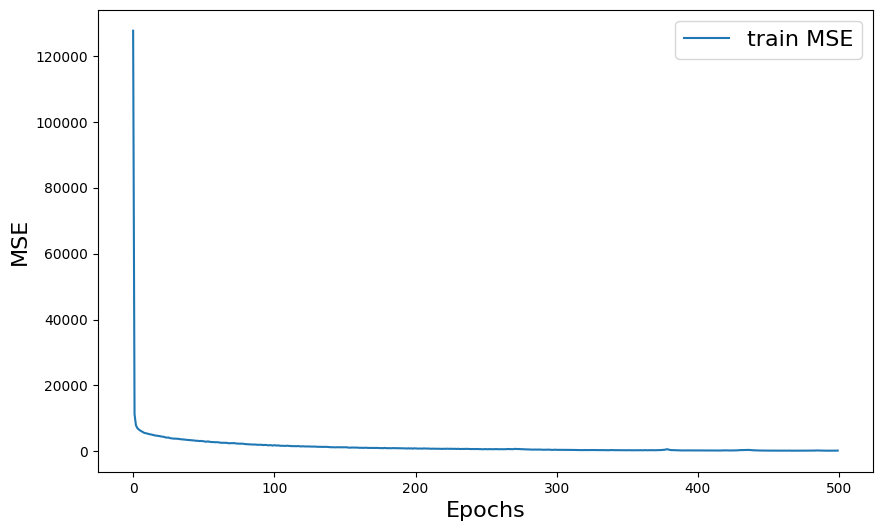

In [14]:
#Training process
train_dataset = MPNNDataset(x_train, y_train)
test_dataset = MPNNDataset(x_test, y_test)
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=5)
history = mpnn.fit(
    train_dataset,
    epochs=500, callbacks=[early_stopping]
)
plt.figure(figsize=(10, 6))
plt.plot(history.history["MSE"], label="train MSE")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("MSE", fontsize=16)
plt.legend(fontsize=16)

In [16]:
#Training set
pred_train= tf.squeeze(mpnn.predict(train_dataset))

mae = metrics.mean_absolute_error(y_train,pred_train)
mse = metrics.mean_squared_error(y_train,pred_train)
rmse = np.sqrt(mse) # or mse**(0.5)
r2 = metrics.r2_score(y_train,pred_train)
print("Results of sklearn.metrics: Validation")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

180/180 [==============================] - 4s 17ms/step
Results of sklearn.metrics: Validation
MAE: 15.88754523992318
MSE: 478.7085678387745
RMSE: 21.879409677566134
R-Squared: 0.9726299586110408


In [17]:
#test set
pred= tf.squeeze(mpnn.predict(test_dataset))

mae = metrics.mean_absolute_error(y_test,pred)
mse = metrics.mean_squared_error(y_test,pred)
rmse = np.sqrt(mse) # or mse**(0.5)
r2 = metrics.r2_score(y_test,pred)
print("Results of sklearn.metrics: Validation")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)


180/180 [==============================] - 3s 16ms/step
Results of sklearn.metrics: Validation
MAE: 19.134491487311
MSE: 904.606848146845
RMSE: 30.076682798254947
R-Squared: 0.9491517992211794


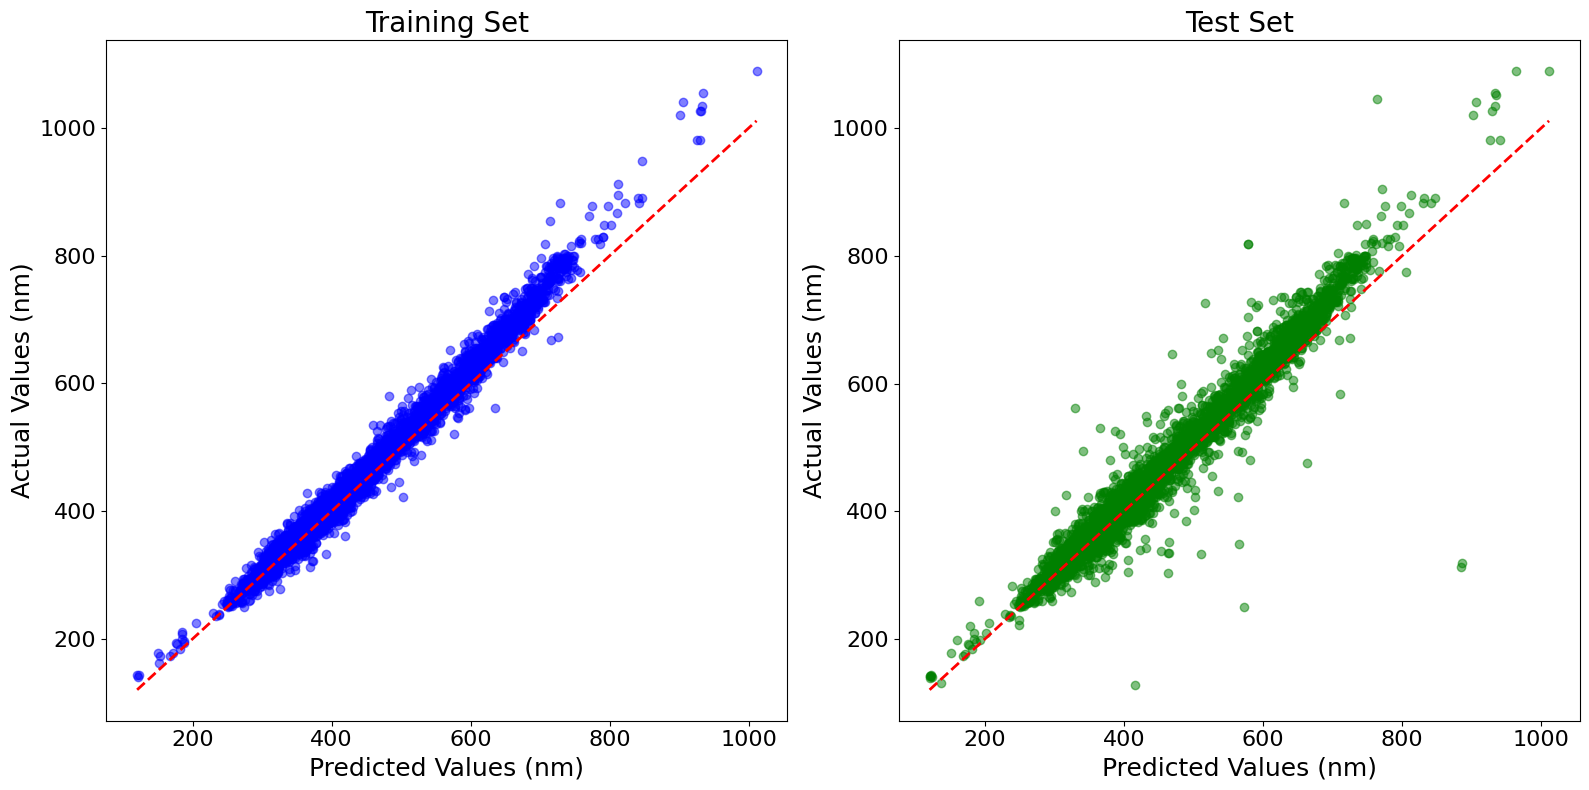

<Figure size 640x480 with 0 Axes>

In [18]:
##plotting scatter plot
# Training set
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.scatter(pred_train, y_train, alpha=0.5, color='blue')
plt.plot([min(pred_train), max(pred_train)], [min(pred_train), max(pred_train)], linestyle='--', color='red', linewidth=2)
plt.title('Training Set', fontsize=20)
plt.xlabel('Predicted Values (nm)', fontsize=18)
plt.ylabel('Actual Values (nm)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)

# Test set
plt.subplot(1, 2, 2)
plt.scatter(pred, y_test, alpha=0.5, color='green')
plt.plot([min(pred), max(pred)], [min(pred), max(pred)], linestyle='--', color='red', linewidth=2)
plt.title('Test Set', fontsize=20)
plt.xlabel('Predicted Values (nm)', fontsize=18)
plt.ylabel('Actual Values (nm)', fontsize=18)
plt.tick_params(axis='both',  which='major', labelsize=16)

plt.tight_layout()
plt.show()
plt.savefig('results.png', dpi=300)
